In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy
from spacy import displacy

import re
import os

In [2]:
data_verb = pd.read_csv('verb_transitivity.tsv', sep='\t')

map_verb_intrans = data_verb[['verb', 'percent_intrans']].set_index('verb').to_dict()['percent_intrans']

In [3]:
nlp = spacy.load('en_core_web_lg')

In [4]:
df = pd.read_csv('./sample-mcd.csv', encoding='latin1')
df = df[['reviewer_id', 'review_time', 'review', 'rating']]

df['rating'] = df['rating'].apply(lambda x: int(x.split(" ")[0]))

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   reviewer_id  100 non-null    int64 
 1   review_time  100 non-null    object
 2   review       100 non-null    object
 3   rating       100 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 3.3+ KB
None


,reviewer_id,review_time,review,rating
0,1,3 months ago,Why does it look like someone spit on my food?...,1
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4
2,3,5 days ago,Made a mobile order got to the speaker and che...,1
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1


In [5]:
# reviews = [
#     "This phone has an amazing camera, perfect for taking high-quality pictures.",
#     "The battery life is impressive, lasting more than a day with heavy use.",
#     "I love how fast this phone charges – it reaches 100% in under an hour!",
#     "The display is bright and vibrant, making videos look stunning.",
#     "The phone feels solid and premium in hand, with great build quality.",
#     "The user interface is smooth and easy to navigate, even for beginners.",
#     "The phone overheats when playing games for too long, which is disappointing.",
#     "I’ve been using this phone for a month, and it hasn't slowed down at all.",
#     "It comes with plenty of storage, perfect for keeping all my photos and apps.",
#     "The fingerprint scanner is fast and accurate, unlocking the phone instantly.",
#     "The speaker quality is decent, but I expected better for this price point.",
#     "It’s a bit bulky in my pocket, but the performance makes up for it.",
#     "The facial recognition feature works even in low light, which is very impressive.",
#     "The phone's 5G support makes a noticeable difference in browsing speed.",
#     "I love the customizable widgets on the home screen, very user-friendly!",
#     "The phone's build feels fragile, so I had to buy a sturdy case right away.",
#     "I miss the headphone jack, but the wireless earbuds work perfectly with it.",
#     "The night mode for the camera is incredible, capturing clear photos in darkness.",
#     "It’s water-resistant, which is a lifesaver when I accidentally spill something.",
#     "The phone lags occasionally when multitasking with several apps open.",
#     "It’s very easy to set up, and transferring my data from my old phone was seamless.",
#     "The haptic feedback feels very responsive and adds to the overall experience.",
#     "I’ve had some issues with the Bluetooth connectivity when using wireless headphones.",
#     "The screen size is perfect for watching movies and gaming on the go.",
#     "The phone’s battery drains quickly when using GPS for long periods.",
#     "I was surprised by how good the front camera is for video calls and selfies.",
#     "The phone supports wireless charging, which is very convenient.",
#     "The software updates are frequent and keep the phone running smoothly.",
#     "It’s lightweight and easy to carry around, even with a protective case on.",
#     "I appreciate the built-in privacy features that help keep my data secure."
# ]

# df = pd.DataFrame(reviews, columns=['review'])

# df

In [6]:
# Load Bing Liu's opinion word dictionary
bing_liu_opinion_words = set()  # Add the actual list of opinion words here

# Function to load opinion words from Bing Liu lexicon
def load_opinion_words(filepath):
    global bing_liu_opinion_words
    temp = pd.read_table(filepath, comment=';', header=None)[0].to_list()
    bing_liu_opinion_words = bing_liu_opinion_words.union(set(temp))


# Load opinion words
current_dir = os.getcwd()
load_opinion_words(os.path.join(current_dir, 'util/opinion-lexicon-English/negative-words.txt'))
load_opinion_words(os.path.join(current_dir, 'util/opinion-lexicon-English/positive-words.txt'))

In [7]:
from contractions import CONTRACTION_MAP

##========== PREPARATION TEXT ===========##

# Contraction
def expand_contractions(sentence, contraction_mapping=CONTRACTION_MAP):
    """
    Expand the contractions in a sentence. For example don't => do not.
    
    Paramters:
    sentence (str): The input sentence to clean.
    contraction_mapping (dict): A dictionary for mapping contractions.
    
    
    Returns:
    str: The expanded contraction sentence.
    """
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
    
    def expanded_match(contraction):
        """
        Filter for expanding the matched contraction.
        
        Parameters:
        contraction (str): The input of contraction
        
        Returns:
        str: The expanded contraction.
        """
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match) if contraction_mapping.get(match) else contraction_mapping.get(match.lower())
        
        expanded_contraction = first_char + expanded_contraction[1:]
        return expanded_contraction
    
    expanded_sentence = contractions_pattern.sub(expanded_match, sentence)
    return expanded_sentence


def remove_extra_spaces(sentence):
    # Use regex to replace multiple spaces with a single space
    return re.sub(r'\s+', ' ', sentence).strip()


def remove_non_ascii(text):
    """
    Remove all non-ASCII characters from the text.

    Parameters:
    text (str): The input text to clean.

    Returns:
    str: The cleaned text with only ASCII characters.
    
    """
    
    return ''.join([char for char in text if ord(char) < 128])

In [8]:
##=========== EXTRACT ASPECT ============##
# Cross product two lists
def cross_product_str(first, second):
    """
    Do cross product

    parameters
    -----------
    first: list/string
    second: list/string

    return: list of string
    """
    temp = []
    if type(first) == str:
        first = [first]
    if type(second) == str:
        second = [second]
    for i in first:
        for j in second:
            text = (i + ' ' + j).strip()
            temp.append(text)
    return temp

def cross_product_tuple(first, second):
    """
    Do cross product

    parameters
    -----------
    first: list/string
    second: list/string

    return: list of tuple
    """
    temp = []
    if type(first) == str:
        first = [first]
    if type(second) == str:
        second = [second]
    for i in first:
        for j in second:
            temp.append((i, j))
    return temp

# Get neglection text
def get_neglect(token):
    for t in token.children:
        if (t.dep_ == 'neg') or (t.dep_ == 'det' and t.text.lower() == 'no'):
            return 'not'
    return ''

# Get token specific pos tag
def get_token_pos(token, pos):
    if type(pos) == str:
        pos = [pos]
    for t in token.children:
        if t.pos_ in pos:
            return t
    return None

def get_token_pos_left(token, pos):
    if type(pos) == str:
        pos = [pos]
    for t in token.children:
        if (t.pos_ in pos) and (t.i < token.i):
            return t
    return None

def get_token_pos_right(token, pos):
    if type(pos) == str:
        pos = [pos]
    for t in token.children:
        if (t.pos_ in pos) and (t.i > token.i):
            return t
    return None
    
# Get token spcific dependency
def get_token_dep(token, dep):
    if type(dep) == str:
        dep = [dep]
    for t in token.children:
        if t.dep_ in dep:
            return t
    return None

def get_token_dep_left(token, dep):
    if type(dep) == str:
        dep = [dep]
    for t in token.children:
        if (t.dep_ in dep) and (t.i < token.i):
            return t
    return None

def get_token_dep_right(token, dep):
    if type(dep) == str:
        dep = [dep]
    for t in token.children:
        if (t.dep_ in dep) and (t.i > token.i):
            return t
    return None

def get_all_token_dep(token, dep):
    result = []
    if type(dep) == str:
        dep = [dep]
    for t in token.children:
        if t.dep_ in dep:
            result.append(t)
    return result

def get_all_token_dep_right(token, dep):
    result = []
    if type(dep) == str:
        dep = [dep]
    for t in token.children:
        if t.dep_ in dep and t.i > token.i:
            result.append(t)
    return result

def get_all_token_dep_left(token, dep):
    result = []
    if type(dep) == str:
        dep = [dep]
    for t in token.children:
        if t.dep_ in dep and t.i < token.i:
            result.append(t)
    return result

# Get token coordinate conjugation
# def get_token_cc(token):
#     for t in token.children:
#         if t.dep_ == 'cc':
#             return t
#     return None

# Crawling all possibile conjunct
def extract_conj(token, neglect=False, lemma=False):
    result = []
    current = get_token_dep(token, dep='conj')
    while current:
        if neglect:
            neg = get_neglect(current)
            # If lemma
            if lemma:
                text = (neg + ' ' + current.lemma_).strip()
            else:
                text = (neg + ' ' + current.text).strip()
                    
            result.append(text)
        else:
            result.append(current.text)
        current = get_token_dep(current, dep='conj')

    return result

# Get sentences that include coordinating conjunction and its conjunct
def get_text_conj(token):
    # Get all sentence of series include the conjugation
    tokens = [token]
    # Get all token
    tokens += extract_conj(token, all_token=True)

    text = ''
    for i, t in enumerate(tokens):
        text = text + t.text
        if i < len(tokens) - 1:
            if t.dep_ == 'cc':
                text += ' '
            else:
                text += ', '

    # text = text.strip()
    return text

# Crawling all possibile adjective pre-modifier
def extract_pre_adj(token, lemma=False):
    result = []
    current_idx = token.i
    for child in token.children:
        if child.pos_ == 'ADJ' and child.i < current_idx:
            if lemma:
                result.append((child.lemma_, child.i))
            else:
                result.append((child.text, child.i))

    # Sort by its index
    result = sorted(result, key=lambda x: x[1])

    # Return only list of string
    result = [item[0] for item in result]

    return result

# Crawling all possible adjective post-modifier
def extract_post_adj(token, lemma=False):
    result = []
    current_idx = token.i
    for child in token.children:
        if child.pos_ == 'ADJ' and child.i > current_idx:
            if lemma:
                result.append((child.lemma_, child.i))
            else:
                result.append((child.text, child.i))

    # Sort by its index
    result = sorted(result, key=lambda x: x[1])

    # Return only list of string
    result = [item[0] for item in result]

    return result

# Crawling all possible adverb
def extract_adv(token, lemma=True):
    conjunctions = [
    # Coordinating conjunctions
    "for", "and", "nor", "but", "or", "yet", "so",
    
    # Subordinating conjunctions
    "although", "because", "since", "if", "when", "while", "before", "after", "unless", "though",
    
    # Correlative conjunctions (listed as single strings)
    "either", "neither", "both", "also", "whether", "as",
    
    # Conjunctive adverbs
    "however", "therefore", "moreover", "consequently", "nevertheless", "thus", "furthermore"
    ]

    result_pre = []
    result_post = []
    current_idx = token.i
    for child in token.children:
        # If pre-position adverb
        if child.pos_ == 'ADV' and child.i < current_idx and child.lemma_.lower() not in conjunctions:
            if lemma:
                result_pre.append((child.lemma_, child.i))
            else:
                result_pre.append((child.text, child.i))

        # If post-position adverb
        if child.pos_ == 'ADV' and child.i > current_idx and child.lemma_.lower() not in conjunctions:
            if lemma:
                result_post.append((child.lemma_, child.i))
            else:
                result_post.append((child.text, child.i))

    # Sort by its index
    result_pre = sorted(result_pre, key=lambda x: x[1])
    result_post = sorted(result_post, key=lambda x: x[1])

    # Return only list of string
    result_pre = [item[0] for item in result_pre]
    result_post = [item[0] for item in result_post]

    return result_pre, result_post

# Crawling preposition phrase after particullar token
def crawling_after_token_prep_phrase(token, neglect=False):
    result = []
    basis_idx = token.i
    prep = get_all_token_dep(token, dep='prep')
    if prep:
        # If contain children: dep pcomp dep VERB pos tag; Until reach dobj or pobj
        for p in prep:
            prep_idx = p.i
            # If the preposition on the left basis token index, continue
            if basis_idx > prep_idx:
                continue
                
            current = get_token_dep(p, dep=['pcomp', 'dobj', 'pobj'])
            # Store objects
            obj = []
            # Store complement
            comp = [p.text]
            while current:
                text = current.text
                # If current token is object, get the pre-modifier adjective
                if current.dep_ in ['dobj', 'pobj']:
                    pre_adj = ' '.join(extract_pre_adj(current))
                    obj += cross_product_str(pre_adj, text)

                    # Extract conjunct object
                    obj_conj = extract_conj(current, neglect=neglect)
                    if len(obj_conj) > 0:
                        obj += obj_conj
                else:
                    comp = cross_product_str(comp, text)
                    
                current = get_token_dep(current, dep=['pcomp', 'dobj', 'pobj'])

            result += cross_product_str(comp, obj)
            
    return result


# # Get the sentence point mapper
# def get_sentence_mapper():
#     sentence_point = {}
#     for i, s in enumerate(doc.sents):
#         sentence_point[i] = (s.start, s.end)
#     return sentence_point
    
# # Get location sentence
# sentence_mapper = get_sentence_mapper(doc)

def get_sentence_location(mapper, position):
    for s in mapper.keys():
        interval = mapper[s]
        if position >= interval[0] and position < interval[1]:
            return s

In [9]:
# Extract all raw aspects
def get_raw_aspects(doc):
    # Define global variables
    global bing_liu_opinion_words
    
    # Define local variables
    storage = []

    # Define helper function
    def is_abnormal_noun(text):
        """
            If text only contains special character/number/both OR total length less than 3 it specified as abnormal.
        """
        if re.match(r'^[0-9\W]+$', token.text) or len(token.text) < 3:
            return True
        else:
            return False

    # Going through all token
    for idx, token in enumerate(doc):
        # Make sure the text is not abnormal
        if is_abnormal_noun(token.text):
            continue

        # If the word is noun and preceded by an adjective
        if idx != 0 and (token.pos_ == 'NOUN' and doc[idx - 1].pos_ == 'ADJ'):
            # If the adjective is an opinion
            if doc[idx - 1].text not in bing_liu_opinion_words:
                # Concatenate adj + word then add to storage
                text = doc[idx - 1].text + ' ' + token.text
                storage.append((text, idx - 1, idx + 1))
            else:
                # Else, add noun only
                text = token.text
                storage.append((text, idx, idx + 1))
            continue
            
        # If the word is noun and preceded by another noun
        if idx != 0 and (token.pos_ == 'NOUN' and doc[idx - 1].pos_ == 'NOUN'):
            text = doc[idx - 1].text + ' ' + token.text
            storage.append((text, idx - 1, idx + 1))
            continue

        # If the word is noun and direct object
        if token.pos_ == 'NOUN' and (token.dep_ == 'dobj'):
            text = token.text
            storage.append((text, idx, idx + 1))
            continue
    
        # If the word is noun and a subject of sentence
        if token.pos_ == 'NOUN' and token.dep_ == 'nsubj':
            text = token.text
            storage.append((text, idx, idx + 1))
            continue
    
        # If the word is noun and a conj of another noun
        if (token.pos_ == 'NOUN' and token.dep_ == 'conj') and (token.head.pos_ == 'NOUN'):
            text = token.text
            storage.append((text, idx, idx + 1))
            continue
    
        # # If the sentence contains SUBJECT VERB, then makes it true
        # if token.dep_ == 'nsubj' and token.head.pos_ == 'VERB':
        #     is_contain_subject_verb = True
    
        # # If token is word that contain pre-modifier
        # if (token.dep_ == 'amod' and token.head.pos_ == 'NOUN'):
        #     if token.head.i != idx + 1:
        #         continue
        #     text = token.text + ' ' + token.head.text
        #     storage.append((text, idx, token.head.i + 1))
    
        # # If token is word that contain post-modifier
        # if (token.dep_ == 'pobj' and token.pos_ == 'NOUN'):
        #     if token.head.dep_ == 'prep' and token.head.head.pos_ == 'NOUN':
        #         text = token.head.head.text + ' ' + token.head.text + ' ' + token.text
        #         start = token.head.head.i
        #         storage.append((text, start, idx + 1))
            
        
        # If token is adverb modifier and its head is NOUN then store it.
        if (token.dep_ == 'advmod' and token.head.pos_ == 'NOUN'):
            text = token.head.text + ' ' + token.text
            storage.append((text, token.head.i, idx + 1))
            # adv_adj_mod.append((text, idx, idx + 1))

    # Sort storage
    storage = list(set(storage))
    storage = sorted(storage, key=lambda x: (x[1], x[0]))

    return storage

# Prunning raw aspect
def prunning_aspect(list_, doc):
    # Define local variables
    drop_idx = []
    storage = {}
    
    # Get sentence mapper and prepare storage
    sentence_points = {}
    for i, s in enumerate(doc.sents):
        sentence_points[i] = (s.start, s.end)
        storage[i] = []

    for idx, item in enumerate(list_):
        # As long as current idx does not more than maximum list_ index
        if idx != len(list_) - 1:
            # Get the next item
            next_item = list_[idx + 1]
            # If current item start position and next item end position are overlapping
            if item[-1] - 1 == next_item[1]:
                # We merge the text based on last text in current item and first text in next item
                append_text = ' '.join(next_item[0].split()[1:])
                # Update next item values
                new_text = item[0] + ' ' + append_text
                new_start = item[1]
                new_end = next_item[-1]
                list_[idx + 1] = (new_text, new_start, new_end)

                # Add current index into dropped index list
                drop_idx.append(idx)
            
            # If current item start position = next item end position (They are next to each other)
            if item[-1] == next_item[1]:
                # Update the next value (do not have to merge the text based on specific text).
                new_text = item[0] + ' ' + next_item[0]
                new_start = item[1]
                new_end = next_item[-1]
                list_[idx + 1] = (new_text, new_start, new_end)

                # Add current index into dropped index list
                drop_idx.append(idx)
                
    list_ = [list_[i] for i in range(len(list_)) if i not in drop_idx]

    # Create return as mapper
    for i, s in enumerate(list_):
        text, start, end = s
        sentence_location = get_sentence_location(sentence_points, start)
        # Update value and store text as lowercase
        storage[sentence_location].append(text.lower())
    return storage

In [10]:
# Generate mapper pronouns-antecedents (subject only)
def get_mapper_pron_ant(doc):
    
    def locate_subject_ant_pron(_doc):
        # Locate potential antecedents and pronouns (subject only)
    
        # Define local variables
        antecedents = []
        pron = []
        prohibit_pronouns = [ 'i', 'you', 'me', 'my', 'mine']
    
        # Get sentence mapper
        sentence_points = {}
        for i, s in enumerate(_doc.sents):
            sentence_points[i] = (s.start, s.end)
        
        for token in _doc:
            # Condition potential antecedents
            # If the token is not pronouns and it's a subject
            if (token.pos_ in ['NOUN', 'PROPN']) and (token.dep_ == 'nsubj'):
                start = token.i
                end = start + 1
                location_sentence = get_sentence_location(sentence_points, start)
                antecedents.append((token, start, location_sentence))
                # Check is there any conj
                # antecedents += extract_conj(token, only_token=True)
        
            # if (token.pos_ != 'PRON') and (token.dep_ == 'dobj' or token.dep_ == 'pobj'):
            #     start = token.i
            #     end = start + 1
            #     location_sentence = get_sentence_location(sentence_points, start)
            #     antecedents.append((token, start, location_sentence))
            #     # Check is there any conj
            #     # antecedents += extract_conj(token, only_token=True)    
        
            # Condition potential pronouns
            # Rule 1
            # If pron is subject (it could be same sentence or previously)
            if (token.pos_ == 'PRON' and token.text.lower() not in prohibit_pronouns) and (token.dep_ == 'nsubj'):
                start = token.i
                end = start + 1
                location_sentence = get_sentence_location(sentence_points, start)
                pron.append((token, start, location_sentence))
                
            # Rule 2
            # If pron is possesion (ant is subject in the same sentence)
            if (token.pos_ == 'PRON' and token.text.lower() not in prohibit_pronouns) and (token.dep_ == 'poss'):
                start = token.i
                end = start + 1
                location_sentence = get_sentence_location(sentence_points, start)
                pron.append((token, start, location_sentence))
        
            # Rule 3
            # If pron is object
            # if (token.pos_ == 'PRON') and (token.dep_ == 'dobj' or token.dep_ == 'pobj'):
            #     start = token.i
            #     end = start + 1
            #     location_sentence = get_sentence_location(sentence_points, start)
            #     pron.append((token, start, location_sentence))
        
        
        return (antecedents, pron)

    # Filter sentence
    def filter_sentence(_list, location):
        temp = []
        for e in _list:
            if e[-1] == location:
                temp.append(e)
        return temp

    # Define local variable
    mapper = {}
    result = None

    antecedents, pronouns = locate_subject_ant_pron(doc)
    
    if len(pronouns) > 0:
        for p in pronouns:
            # Current status
            is_success = False

            # Get current text, index token, and location sentence token
            token_pron, index_pron, sent_pron = p
            current_sentence = sent_pron
            
            while current_sentence > -1:
                # Get the antecedents
                filter_antecedents = filter_sentence(antecedents, current_sentence)

                # If the filter antecedents exist
                if len(filter_antecedents) > 0:
                    for ant in filter_antecedents:
                        token_ant, index_ant, sent_ant = ant
                        # If antecedent is subject and pronouns is subject or possession and antecedent on the left of pronoun
                        if ('subj' in token_ant.dep_) and ('subj' in token_pron.dep_ or 'poss' in token_pron.dep_) and (index_ant < index_pron):
                            mapper[index_pron] = index_ant
                            is_success = True
                            break
                        # if ('obj' in token_ant.dep_ and 'obj' in token_pron.dep_) and (index_ant < index_pron):
                        #     mapper[index_pron] = index_ant
                        #     is_success = True
                        #     break
                
                # If already success, break it.
                if is_success:
                    break
                    
                current_sentence -= 1

    return mapper

In [11]:
def get_raw_abilities(doc):
    storage = {}
    first_person_pronouns = [ 'i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']

    # Get sentence mapper and prepare storage
    sentence_points = {}
    for i, s in enumerate(doc.sents):
        sentence_points[i] = (s.start, s.end)
        storage[i] = []

    # Get mapper pronoun and antecedents
    mapper_pron_ant = get_mapper_pron_ant(doc)
        
    for idx, token in enumerate(doc):
        subjects = []
        abilities = []
    
        # If the token is verb
        if token.pos_ == 'VERB':
            
            for t in token.children:
                # Check if the token children contain subject.
                if t.dep_ == 'nsubj':
                    # Get current child index and text
                    current_idx = t.i
                    text = t.lemma_
                    # If the current child is first person pronoun
                    if t.pos_ == 'PRON' and t.text.lower() in first_person_pronouns:
                        # The token is reference to "the user"
                        text = 'the user'
                    # If the current child is pronoun and its current_idx in mapper_pron_ant
                    elif t.pos_ == 'PRON' and current_idx in mapper_pron_ant.keys():
                        # Change current token
                        idx_map = mapper_pron_ant[current_idx]
                        t = doc[idx_map]
                        text = t.lemma_
                    # If the current child is pronoun (but not in mapper_pron_ant keys), or only contains special characters or numbers, or
                    #   length text less than 3
                    elif (t.pos_ == 'PRON') or (re.match(r'^[0-9\W]+$', t.text)) or (len(t.text) < 3):
                        continue
                    subjects.append(text)
                    # Looping through the children of subject.
                    subjects += extract_conj(t, lemma=True)

            if len(subjects) > 0:
                # Make sure the subject is unique
                subjects = list(set(subjects))
                
                # Store the result
                result = cross_product_tuple(subjects, token.lemma_)
                # Result should be lowercase
                result = [(s.lower(), a.lower()) for s, a in result]
                sentence_location = get_sentence_location(sentence_points, idx)
                storage[sentence_location] += result
    
    
        # If the token is aux
        elif token.pos_ == 'AUX':
            
            # Looping through children
            for t in token.children:
                if t.dep_ == 'nsubj':
                    # Get current child index and text
                    current_idx = t.i
                    text = t.lemma_
                    # If the current child is pronoun I, me, my
                    if t.pos_ == 'PRON' and t.text.lower() in first_person_pronouns:
                        # The token is reference to "the user"
                        text = 'the user'
                    # If the current child is pronoun and its current_idx in mapper_pron_ant
                    elif t.pos_ == 'PRON' and current_idx in mapper_pron_ant.keys():
                        # Change current token
                        idx_map = mapper_pron_ant[current_idx]
                        t = doc[idx_map]
                        text = t.lemma_
                    # If the current child is pronoun (but not in mapper_pron_ant keys), or only contains special characters or numbers, or
                    #   length text less than 3
                    elif (t.pos_ == 'PRON') or (re.match(r'^[0-9\W]+$', t.text)) or (len(t.text) < 3):
                        continue
                        
                    subjects.append(text)
                    # Looping through the children of subject.
                    subjects += extract_conj(t, lemma=True)

                # Check if the neglect exist and depend on token aux
                neg = get_neglect(token)
                if t.dep_ == 'acomp':
                    # If neglection does not exist after aux, then check if it exist at first adj/verb
                    if not neg:
                        neg = get_neglect(t)
                    abilities.append(t.lemma_)
                    # Looping through the children of subject
                    # If neglection does not appear in after aux or before first subject.
                    #  Then check all neglection in first conjugation.
                    if not neg:
                        abilities += extract_conj(t, neglect=True, lemma=True)
                    else:
                        abilities += extract_conj(t, lemma=True)
                        abilities = cross_product_str(neg, abilities)
    
            if len(subjects) > 0 and len(abilities) > 0 :
                # Make sure the subject is unique
                subjects = list(set(subjects))

                # Store the result
                result = cross_product_tuple(subjects, abilities)
                # Result should be lowercase
                result = [(s.lower(), a.lower()) for s, a in result]
                sentence_location = get_sentence_location(sentence_points, idx)
                storage[sentence_location] += result
            
        # If the token is noun
        elif token.pos_ == 'NOUN':
            # If only contains special characters or numbers, or length text less than 3
            if re.match(r'^[0-9\W]+$', token.text) or len(token.text) < 3:
                continue
            for t in token.lefts:
                if t.pos_ == 'ADJ':
                    neg = get_neglect(t)
                    if neg:
                        abilities.append(neg + ' ' + t.lemma_)
                    else:
                        abilities.append(t.lemma_)
    
            # If the token contain abilities, then we check is there any conjugation
            if len(abilities) > 0:
                subjects.append(token.lemma_)
                subjects += extract_conj(token, lemma=True)
                # Make sure the subject is unique
                subjects = list(set(subjects))


                # Store the result
                result = cross_product_tuple(subjects, abilities)
                # Result should be lowercase
                result = [(s.lower(), a.lower()) for s, a in result]
                sentence_location = get_sentence_location(sentence_points, idx)
                storage[sentence_location] += result

    return storage

In [12]:
def subject_active_rules(token):
    abilities = []
    # Go to its head
    head = token.head

    # Get neglect; If there is no neglect, return empty text.
    neg = get_neglect(head)

    # If head is Verb.
    if head.pos_ == 'VERB':

        # Get all conjunct (except adjective with dependency acomp)
        if neg:
            verb_conjunct = extract_conj(head)
        else:
            # If neglect do not come at first, then check neglection in front each conjunct.
            verb_conjunct = extract_conj(head, neglect=True)

        #### ====== PUT FOR LOOP EACT VERB CONJUNCT ========== ###

        # If the verb is posession
        if head.lemma_ == 'have':

            # Get direct object
            obj = get_token_dep(head, dep='dobj')

            # If direct object exist
            if obj:
                # Extract all possible pre-modifier adjectives
                pre_adj_text = ' '.join(extract_pre_adj(obj))

                # Concatenate components into: Adj (optional) + Direct object
                ability = cross_product_str(pre_adj_text, obj.text)
                # Concatenate components into: Verb (Have) + Adj (optional) + Direct object
                ability = cross_product_str(head.lemma_, ability)
                # Concatenate components into: not (optional) + Verb (Have) + Adj (optional) + Direct object
                ability = cross_product_str(neg, ability)

                # Add the ability into abilities
                abilities += ability
                # EXPECTED PATTERN: Subject + not (optional) + Verb (Have) + Adj (optional) + Direct object

                # If the object has conjunct
                obj_conjunct = extract_conj(obj)
                if len(obj_conjunct) > 0:
                    # Concatenate components into: Verb (Have) + Conjunct
                    ability = cross_product_str(head.lemma_, obj_conjunct)
                    # Concatenate components into: not (optional) + Verb (Have) + Conjunct
                    ability = cross_product_str(neg, ability)

                    # Add the ability into abilities
                    abilities += ability
                    # EXPECTED PATTERN: Subject + not (optional) + Verb (Have) + Direct object
                    # Note: Since normaly, If direct object is noun/propn/pron the conjuncts are noun/propn/pron too.
                    #        This rule follow this concept. In somehow, the conjunct could be adjective or another verb.

            # If the verb is posession but do not have direct object (object that the subject posessed) return empty list
            else:
                return []
        else:
            ## ============ GET POSSIBLY COMPONENTS REQUIREMENT =========== ##
            # Get aux
            aux = get_token_dep(head, dep='aux')

            ##### FIX HERE ######
            # Get Pre and post adv
            # pre_adv, post_adv = extract_adv(head)
            # # Convert pre and post adverb into string
            # pre_adv = (' '.join(pre_adv)).strip()
            # post_adv = (' '.join(post_adv)).strip()
            
            # Get pre and post adverb after verb
            advmod_right_main = get_token_dep_right(head, dep=['advmod', 'npadvmod'])
            post_adv = []
            if advmod_right_main:
                # Get pre and post adverb after post main verb
                pre_advmod_right_main, post_advmod_right_main = extract_adv(advmod_right_main)
                pre_advmod_right_main = ' '.join(pre_advmod_right_main)
                post_advmod_right_main = ' '.join(post_advmod_right_main)

                post_adv = [pre_advmod_right_main, advmod_right_main.text, post_advmod_right_main]
            post_adv = (' '.join(post_adv)).strip()

            advmod_left_main = get_token_dep_left(head, dep=['advmod', 'npadvmod'])
            pre_adv = []
            if advmod_left_main:
                # Get pre and post adverb after pre main verb
                pre_advmod_left_main, post_advmod_left_main = extract_adv(advmod_left_main)
                pre_advmod_left_main = ' '.join(pre_advmod_left_main)
                post_advmod_left_main = ' '.join(post_advmod_left_main)
                
                pre_adv = [pre_advmod_left_main, advmod_left_main.text, post_advmod_left_main]
            pre_adv = (' '.join(pre_adv)).strip()
            

            # Get Preposition after verb
            prep_after_verb = crawling_after_token_prep_phrase(head)

            # Get direct object verb
            obj = get_token_dep(head, dep='dobj')
            
            # Get intransitive rate score
            int_rate = map_verb_intrans.get(head.text) or map_verb_intrans.get(head.lemma_)
            # If the verb is not in the mapper ( we assume it is transitive verb )
            if not int_rate:
                int_rate = 0


            ###===================== CONDITION =====================###

            if (advmod_right_main) or (prep_after_verb) or (obj):
                # If adverb after verb exist ==> Subject + aux (optional) + not (optional) + adv (optional) + verb + adv + preposition phrase (optional)
                if advmod_right_main:
                    # Concatenate components into: adv (optional) + verb
                    ability = cross_product_str(pre_adv, head.text)
                    # Concatenate components into: not (optional) + adv (optional) + verb
                    ability = cross_product_str(neg, ability)
                    # Concatenate components into: not (optional) + adv (optional) + verb + adv
                    ability = cross_product_str(ability, post_adv)
        
                    # If aux exist, add the text into ability_text
                    if aux:
                        # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb + adv
                        ability = cross_product_str(aux.text, ability)

                    # If preposition phrase after adverb exist.
                    ######## EDIT HERE ################
                    prep_after_advmod = crawling_after_token_prep_phrase(advmod_right_main)
                    if prep_after_advmod:
                        # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb + adv + preposition phrase (optional)
                        ability = cross_product_str(ability, prep_after_advmod)
                    
                    # EXPECTED PATTERN: Subject + aux (optional) + not (optional) + adv (optional) + verb + adv + prepositional phrase (optional)
                    abilities += ability

                # If prep after verb ==> Subject + aux (optional) + not (optional) + adv (optional) + verb + preposition phrase
                if prep_after_verb:
                    # Concatenate components into: adv (optional) + verb
                    ability = cross_product_str(pre_adv, head.text)
                    # Concatenate components into: not (optional) + adv (optional) + verb
                    ability = cross_product_str(neg, ability)
                    # If auxiliary token exist
                    if aux:
                        # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb
                        ability = cross_product_str(aux.text, ability)
    
                    # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb + preposition phrase
                    ability = cross_product_str(ability, prep_after_verb)
    
                    # EXPECTED PATTERN: Subject + aux (optional) + not (optional) + adv (optional) + verb + preposition phrase
                    abilities += ability

                # If direct object exist ==> Subject + aux (optional) + not (optional) + adv (optional) + verb + adj (optional) + Direct object
                if obj:
                    # Get pre adjective modifier direct object and convert in into string
                    pre_adj = ' '.join(extract_pre_adj(obj))
                    # Concatenate components into: adv (optional) + verb
                    ability = cross_product_str(pre_adv, head.text)
                    # Concatenate components into: not (optional) + adv (optional) + verb
                    ability = cross_product_str(neg, ability)
                    # If auxiliary token exist
                    if aux:
                        # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb
                        ability = cross_product_str(aux.text, ability)
                    # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb + adj (optional)
                    ability = cross_product_str(ability, pre_adj)
                    # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb + adj (optional) + Direct object
                    ability = cross_product_str(ability, obj.text)
                    
                    # EXPECTED PATTERN: Subject + aux (optional) + not (optional) + adv (optional) + verb + adj (optional) + Direct object
                    abilities += ability

            else:
                # If do not contain any of that, but intransitive verb ==> Subject + aux (optional) + not (optional) + adv (optional) + verb
                if int_rate > 0.5:
                    # Concatenate components into: adv (optional) + verb
                    ability = cross_product_str(pre_adv, head.text)
                    # Concatenate components into: not (optional) + adv (optional) + verb
                    ability = cross_product_str(neg, ability)
        
                    # If aux exist, add the text into ability_text
                    if aux:
                        # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb
                        ability = cross_product_str(aux.text, ability)

                    # EXPECTED PATTERN: aux (optional) + not (optional) + adv (optional) + verb
                    abilities += ability

    # If head is aux
    elif head.pos_ == 'AUX':
        # Get the token
        # NOTE: if 'AUX' is root, only have one adjective with dependency acomp.
        adj_token = get_token_dep(head, dep='acomp')
        noun_token = get_token_pos_right(head, pos=['NOUN', 'PROPN'])

        if adj_token:
            # Get Preposition after adjective
            prep_after_adj = ' '.join(crawling_after_token_prep_phrase(adj_token))

            # Concatenate components into: aux + not (optional)
            ability = cross_product_str(head.text, neg)
            # Concatenate components into: aux + not (optional) + adj
            ability = cross_product_str(ability, adj_token.text)
            # Concatenate components into: aux + not (optional) + adj + preposition phrase (optional)
            ability = cross_product_str(ability, prep_after_adj)

            # EXPECTED PATTERN: Subject + aux + not (optional) + adj
            abilities += ability

            # Get all conjunct (except adjective with dependency acomp)
            if neg:
                adj_conjunct = extract_conj(adj_token)
            else:
                # If neglect do not come at first, then check neglection in front each conjunct.
                adj_conjunct = extract_conj(adj_token, neglect=True)

            if len(adj_conjunct) > 0:
                # Concatenate components into: aux + not (optional)
                ability = cross_product_str(head.text, neg)
                # Concatenate components into: aux + not (optional) + adj
                ability = cross_product_str(ability, adj_conjunct)
                # EXPECTED PATTERN: Subject + aux + not (optional) + adj
                abilities += ability

        elif noun_token:
            # Get Pre-modifier adjective
            pre_adj_noun = ' '.join(extract_pre_adj(noun_token))
            # Concatenate components into: aux + not (optional)
            ability = cross_product_str(head.text, neg)
            # Concatenate components into: aux + not (optional) + pre-modifier adjective (optional)
            ability = cross_product_str(ability, pre_adj_noun)
            # Concatenate components into: aux + not (optional) + pre-modifier adjective (optional) + noun
            ability = cross_product_str(ability, noun_token.text)

            # EXPECTED PATTERN: Subject + aux + not (optional) + pre-modifier adjective (optional) + noun
            abilities += ability

            # Get all conjunct
            if neg:
                noun_conjunct = extract_conj(noun_token)
            else:
                # If neglect do not come at first, then check neglection in front each conjunct.
                noun_conjunct = extract_conj(noun_token, neglect=True)

            if len(noun_conjunct) > 0:
                # Concatenate components into: aux + not (optional)
                ability = cross_product_str(head.text, neg)
                # Concatenate components into: aux + not (optional) + noun
                ability = cross_product_str(ability, noun_conjunct)
                # EXPECTED PATTERN: Subject + aux + not (optional) + noun
                abilities += ability
    return abilities

In [13]:
def subject_passive_rules(token):
    abilities = []
    # Get the token head (verb). Since passive form at least form: Subject + auxpass + verb 
    head = token.head
    if head.pos_ != 'VERB':
        return []

    ##================= GET ALL POSSIBLE COMPONENTS ===============##
    # Get neglect; If there is no neglect, return empty text.
    neg = get_neglect(head)

    # Get auxpass token
    auxpass = get_token_dep(head, dep='auxpass')
    if not auxpass:
        # Since passive sentence must have auxpass in its component.
        return []

    # Get aux token
    aux = get_token_dep(head, dep='aux')

    # Get advmod after verb token
    advmod_main = get_token_dep_right(head, dep=['advmod', 'npadvmod'])
    if advmod_main:
        pre_advmod_main, post_advmod_main = extract_adv(advmod_main)
        pre_advmod_main = ' '.join(pre_advmod_main)
        post_advmod_main = ' '.join(post_advmod_main)

    # Get the agent token
    agent = get_token_dep_right(head, dep='agent')
    obj_agent = None
    # If the agent token exist
    if agent:
        # Get the object that refers to 'agent' token
        obj_agent = get_token_dep(agent, dep=['pobj', 'dobj'])

    # Get prepositional phrase
    if neg:
        prep_after_verb = crawling_after_token_prep_phrase(head)
    else:
        prep_after_verb = crawling_after_token_prep_phrase(head, neglect=True)

    # Get xcomp token
    xcomp = get_token_dep(head, dep='xcomp')
    # Initalize object and advmod of xcomp.
    obj_xcomp = None
    advmod_xcomp = None
    if xcomp:
        # Get the aux, adv, and obj of xcomp tokens.
        aux_xcomp = get_token_dep(xcomp, dep='aux')
        obj_xcomp = get_token_dep(xcomp, dep=['pobj', 'dobj'])
        advmod_xcomp = get_token_dep_right(xcomp, dep='advmod')
        # If adv modifier of xcomp exist
        if advmod_xcomp:
            # Get pre and post adverb of main adverb modifier xcomp.
            pre_advmod_xcomp, post_advmod_xcomp = extract_adv(advmod_xcomp)
            pre_advmod_xcomp = ' '.join(pre_advmod_xcomp)
            post_advmod_xcomp = ' '.join(post_advmod_xcomp)

    ##================= STORING ABILITIES ===============##     
    # Store ability: If adverb modifier exist
    if advmod_main:
        # If aux exist
        if aux:
            # Concatenate components: aux (optional) + neg (optional)
            ability = cross_product_str(aux.text, neg)
            # Concatenate components: aux (optional) + neg (optional) + auxpass
            ability = cross_product_str(ability, auxpass.text)
        else:
            # Concatenate components: auxpass + neg (optional)
            ability = cross_product_str(auxpass.text, neg)

        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
        ability = cross_product_str(ability, head.text)

        # If pre adverb exist
        if pre_advmod_main:
            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + pre-advmod (optional)
            ability = cross_product_str(ability, pre_advmod_main)
        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + pre-advmod (optional) + advmod
        ability = cross_product_str(ability, advmod_main.text)

        # Get prepositional phrase after adverb
        prep_after_adv = crawling_after_token_prep_phrase(advmod_main)
        if prep_after_adv:
            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + pre-advmod (optional)
            #                            + advmod + preposition phrase (optional)
            ability = cross_product_str(ability, prep_after_adv)

        # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + pre-advmod (optional)
        #                      + advmod + preposition phrase (optional)
        abilities += ability

        # Get all the adverb conjuncts
        # If neglection exist
        if neg:
            # It assume that all conjuncts are neglection 
            advmod_main_conj = extract_conj(advmod_main)
        else:
            # If neglect do not come at first, then check neglection in front each conjunct
            advmod_main_conj = extract_conj(advmod_main, neglect=True)

        # If adverb has conjunct                
        if len(advmod_main_conj) > 0:
            # If contain aux
            if aux:
                # Concatenate components: aux (optional) + neg (optional)
                ability = cross_product_str(aux.text, neg)
                # Concatenate components: aux (optional) + neg (optional) + auxpass
                ability = cross_product_str(ability, auxpass.text)
            else:
                # Concatenate components: auxpass + neg (optional)
                ability = cross_product_str(auxpass.text, neg)

            # Concatenate components: aux (optional) + neg (optional) + auxpass
            ability = cross_product_str(ability, head.text)
            # Concatenate components: aux (optional) + neg (optional) + auxpass + advmod
            ability = cross_product_str(ability, advmod_main_conj)
            # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass
            abilities += ability

    # Store ability: If agent and object agent token exist
    if obj_agent and agent:
        # If aux exist
        if aux:
            # Concatenate components: aux (optional) + neg (optional)
            ability = cross_product_str(aux.text, neg)
            # Concatenate components: aux (optional) + neg (optional) + auxpass
            ability = cross_product_str(ability, auxpass.text)
        else:
            # Concatenate components: auxpass + neg (optional)
            ability = cross_product_str(auxpass.text, neg)

        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb 
        ability = cross_product_str(ability, head.text)
        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + agent
        ability = cross_product_str(ability, agent.text)

        # Get the pre adjective of object
        pre_adj = ' '.join(extract_pre_adj(obj_agent))
        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + agent + adj (optional)
        ability = cross_product_str(ability, pre_adj)
        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + agent + adj (optional) + object
        ability = cross_product_str(ability, obj_agent.text)
        # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + agent + adj (optional) + object
        abilities += ability

        # Get all object conjuncts
        if neg:
            obj_agent_conj = extract_conj(obj_agent)
        else:
            # If neglect do not come at first, then check neglection in front each conjunct.
            obj_agent_conj = extract_conj(obj_agent, neglection=True)
        # If object conjuncts exist
        if len(obj_agent_conj) > 0:
            # If aux exist
            if aux:
                # Concatenate components: aux (optional) + neg (optional)
                ability = cross_product_str(aux.text, neg)
                # Concatenate components: aux (optional) + neg (optional) + auxpass
                ability = cross_product_str(ability, auxpass.text)
            else:
                # Concatenate components: auxpass + neg (optional)
                ability = cross_product_str(auxpass.text, neg)

            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
            ability = cross_product_str(ability, head.text)
            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + object
            ability = cross_product_str(ability, obj_agent_conj)
            # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + object
            abilities += ability

    # Store ability: If preposition after verb exist
    if prep_after_verb:
        # If aux exist
        if aux:
            # Concatenate components: aux (optional) + neg (optional)
            ability = cross_product_str(aux.text, neg)
            # Concatenate components: aux (optional) + neg (optional) + auxpass
            ability = cross_product_str(ability, auxpass.text)
        else:
            # Concatenate components: auxpass + neg (optional)
            ability = cross_product_str(auxpass.text, neg)

        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
        ability = cross_product_str(ability, head.text)
        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + preposition phrase
        ability = cross_product_str(ability, prep_after_verb)
        # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + preposition phrase (optional)
        abilities += ability

    # Store ability: If xcomp exist
    if xcomp:
        # If aux exist
        if aux:
            # Concatenate components: aux (optional) + neg (optional)
            ability = cross_product_str(aux.text, neg)
            # Concatenate components: aux (optional) + neg (optional) + auxpass
            ability = cross_product_str(ability, auxpass.text)
        else:
            # Concatenate components: auxpass + neg (optional)
            ability = cross_product_str(auxpass.text, neg)

        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
        ability = cross_product_str(ability, head.text)
        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp
        ability = cross_product_str(ability, aux_xcomp.text)
        # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp
        ability = cross_product_str(ability, xcomp.text)

        # Store ability: If object xcomp exist
        if obj_xcomp:
            # Get the pre adjective of object
            pre_adj = ' '.join(extract_pre_adj(obj_xcomp))
            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + adj (optional)
            ability = cross_product_str(ability, pre_adj)
            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + adj (optional) + object
            ability = cross_product_str(ability, obj_xcomp.text)
            # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + adj (optional) + object
            abilities += ability
                    
            # Get all object conjuncts
            if neg:
                obj_xcomp_conj = extract_conj(obj_xcomp)
            else:
                # If neglect do not come at first, then check neglection in front each conjunct.
                obj_xcomp_conj = extract_conj(obj_xcomp, neglect=True)
            
            # If object conjuncts exist
            if len(obj_xcomp_conj) > 0:
                # If aux exist
                if aux:
                    # Concatenate components: aux (optional) + neg (optional)
                    ability = cross_product_str(aux.text, neg)
                    # Concatenate components: aux (optional) + neg (optional) + auxpass
                    ability = cross_product_str(ability, auxpass.text)
                else:
                    # Concatenate components: auxpass + neg (optional)
                    ability = cross_product_str(auxpass.text, neg)
    
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
                ability = cross_product_str(ability, head.text)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp
                ability = cross_product_str(ability, aux_xcomp.text)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp
                ability = cross_product_str(ability, xcomp.text)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + object
                ability = cross_product_str(ability, obj_xcomp_conj)
                # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + object
                abilities += ability
        
        # Store ability: If advmod xcomp exist
        if advmod_xcomp:
            # If pre advmod xcomp exist
            if pre_advmod_xcomp:
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xomp + xcomp + pre-advmod (optional)
                ability = cross_product_str(ability, pre_advmod_xcomp)
                
            # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xomp + xcomp + pre-advmod (optional) + advmod
            ability = cross_product_str(ability, advmod_xcomp.text)
            # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + aux-xomp + xcomp + pre-advmod (optional) + advmod
            abilities += ability  

            # Get all advmod conjuncts
            if neg:
                advmod_xcomp_conj = extract_conj(advmod_xcomp)
            else:
                # If neglect do not come at first, then check neglection in front each conjunct.
                advmod_xcomp_conj = extract_conj(advmod_xcomp, neglect=True)
            # If advmod conjuncts exist
            if len(advmod_xcomp_conj) > 0:
                if aux:
                    # Concatenate components: aux (optional) + neg (optional)
                    ability = cross_product_str(aux.text, neg)
                    # Concatenate components: aux (optional) + neg (optional) + auxpass
                    ability = cross_product_str(ability, auxpass.text)
                else:
                    # Concatenate components: auxpass + neg (optional)
                    ability = cross_product_str(auxpass.text, neg)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb
                ability = cross_product_str(ability, head.text)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp
                ability = cross_product_str(ability, aux_xcomp.text)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp
                ability = cross_product_str(ability, xcomp.text)
                # Concatenate components: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + advmod
                ability = cross_product_str(ability, advmod_xcomp_conj)
                # EXPECTED PATTERN: aux (optional) + neg (optional) + auxpass + verb + aux-xcomp + xcomp + advmod
                abilities += ability
               
    return abilities

In [14]:
def get_raw_abilities(doc, ant_first_pron='the user'):
    # Define local variable.
    storage = {}
    first_person_pronouns = [ 'i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']
    pronouns = [
    "he", "she", "they", "it", # Personal Pronouns (Subjective)
    "him", "her", "them", "it", "you",  # Personal Pronouns (Objective)
    "his", "hers", "theirs", "its", "mine", "yours", "ours",  # Possessive Pronouns
    "her", "their", "its",  # Possessive Adjectives
    "himself", "herself", "themself", "themselves", "Itself",  # Reflexive Pronouns,
    "this", "that", "these", "those", # Demonstrative Pronouns
    "who", "whom", "whose", "which", "that"  # Relative Pronouns
    ]


    # Get sentence mapper and prepare storage
    sentence_points = {}
    for i, s in enumerate(doc.sents):
        sentence_points[i] = (s.start, s.end)
        storage[i] = []

    # Get mapper pronoun and antecedents
    mapper_pron_ant = get_mapper_pron_ant(doc)

    # Define local variable.
    result = []
    for idx, token in enumerate(doc):
        abilities = []

        ## ==================== SUBJECT ACTIVE SENTENCE =========================== ##
        # If token is subject (should be nsubj and nsubjpass). This time only nsubj
        # In case active sentence form
        if token.dep_ == 'nsubj':
            abilities += subject_active_rules(token)

        ## ==================== SUBJECT PASSIVE SENTENCE =========================== ##
        # If sentence is passive form.
        if token.dep_ == 'nsubjpass':
            abilities += subject_passive_rules(token)
                
        # Store final result
        if len(abilities) > 0:
            # Subject handling
            subject = token.lemma_
            # current_idx = token.i
            # If the subject is pronouns and first person pronouns
            if token.pos_ == 'PRON' and token.text.lower() in first_person_pronouns:
                subject = ant_first_pron
            # If subject is pronouns and its token location in mapper_pron_ant
            elif token.pos_ == 'PRON' and idx in mapper_pron_ant.keys():
                # Get the antecedent index location
                idx_map = mapper_pron_ant[idx]
                # Change current token subject
                token = doc[idx_map]
                subject = token.lemma_
            # If the current child is pronoun (but not in mapper_pron_ant keys)
            elif token.pos_ == 'PRON' and token.text.lower() in pronouns:
                continue
            # If token only contains special characters or numbers, or length text less than 3 (NOT PRONOUNS)
            elif (re.match(r'^[0-9\W]+$', token.text)) or (len(token.text) < 3):
                continue
                
            # Get all conj subject + current subject
            subjects = [subject] + extract_conj(token)
            # # Store result
            # result += cross_product_tuple(subjects, abilities)
            # Storage final result
            sentence_location = get_sentence_location(sentence_points, idx)
            storage[sentence_location] += cross_product_tuple(subjects, abilities)

    # Storing final result
    return storage

In [15]:
def process_ability(x):
    # Prepare sentence
    texts = remove_extra_spaces(x)
    texts = expand_contractions(x)
    texts = remove_non_ascii(x)

    # Get aspect
    doc = nlp(texts)
    mapper_pron_ant = get_mapper_pron_ant(doc)
    result = get_raw_abilities(doc)
    
    return result

def preprocessing(x):
    # Prepare sentence
    texts = remove_extra_spaces(x)
    texts = expand_contractions(x)
    texts = remove_non_ascii(x)
    return texts
    

text = "Made a mobile order got to the speaker and checked it in. "+\
        "Line was not moving so I had to leave otherwise IÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯"+\
        "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯"+\
        "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯"+\
        "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½d be late for work." +\
        "Never got the refund in the app. I called them and they said I could only get my money back in person because it was stuck in the system."+\
        "Went there in person the next day  and the manager told me she wasnÃÂ¯ÃÂ¿"
text = "If I  could give this location a zero on customer service, I  would. Pulled into drive through at 8:07 and placed a simple order."+\
        " I order a regular hamburg and cookies. Once I paid and pulled up to the window to pick up, "+\
        "I  was told to pull up to the #1 space. I sat there and sat there and.........25 minutes later, no order. "+\
        "I  went in and no one was at the counter. I yelled 'hello' three times. A young lady came up asking who was handling the front counter. "+\
        "A young girl appeared. To make this complaint shorter, I  showed my receipt and another 5 minutes later I got my order. "+\
        "There was another order with a drink sitting on the counter that never got to the person who ordered it. "+\
        "After getting home, I  had no regular hamburg but had cookies. Everyone, don't even bother going to this location again. "+\
        "It's a horrible experience every time as you can see by other reviews."
text = "I'm not really a huge fan of fast food, but I have 2 teenage daughter's who enjoy McDs. "+\
        "The staff here is always friendly and ALWAYS get their orders correct. By far one of the best McDs I have ever been to."+\
        " I always enjoy and appreciate quality service from quality people... and you'll definitely find it here. At least from the evening crew."+\
        "Haven't been here during the day. My girls joke that I go here so often to get them food, that the staff is going to end up knowing me and "+\
        "having their order ready to go. Lmao Great people and excellent service. ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯"
# text = "Just spent 10 minutes waiting at this McDonald's ." +\
#         "According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there," +\
#         " sure enough one employee seated in the lobby and another at the window. She told me they were closed." +\
#         " Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep." +\
#         "One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."

doc = nlp(preprocessing(text))
displacy.render(doc, 'dep')
for idx, sent in enumerate(doc.sents):
    print(f"{idx}. ", sent)
sample_ability = process_ability(text)
sample_ability

0.  I'm not really a huge fan of fast food, but I have 2 teenage daughter's who enjoy McDs.
1.  The staff here is always friendly and ALWAYS get their orders correct.
2.  By far one of the best McDs I have ever been to.
3.  I always enjoy and appreciate quality service from quality people... and you'll definitely find it here.
4.  At least from the evening crew.
5.  Haven't been here during the day.
6.  My girls joke that I go here so often to get them food, that the staff is going to end up knowing me and having their order ready to go.
7.  Lmao Great people and excellent service.


{0: [('the user', "'m not huge fan"), ('the user', 'have teenage daughter')],
 1: [('staff', 'is friendly')],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [('girl', 'joke'), ('the user', 'go here'), ('staff', 'is going')],
 7: []}

In [16]:
text = "I am here watching tv and looking at my brother"
doc = nlp(text)
displacy.render(doc, 'dep')

In [17]:
# df['review'].iloc[33]

In [18]:
def process_aspect(x, mapper_1=None, mapper_2=None): 
    # Prepare sentence
    texts = remove_extra_spaces(x)
    texts = expand_contractions(x)
    texts = remove_non_ascii(x)

    # Get aspect
    doc = nlp(texts)
    result = get_raw_aspects(doc)
    result = prunning_aspect(result, doc)

    return result

text = "Just spent 10 minutes waiting at this McDonald's ." +\
        "According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there," +\
        " sure enough one employee seated in the lobby and another at the window. She told me they were closed." +\
        " Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep." +\
        "One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."
# text = "We hit it off pretty good in the beginning everything was great but that didn" +\
#         "ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½t last long. I mean the service is fast but with attitude an"
sample_asp = process_aspect(text)
sample_asp

{0: ['minutes'],
 1: [],
 2: [],
 3: [],
 4: ['mcdonald'],
 5: ['corporate power house', 'reputation'],
 6: ['unprofessional experiences', 'food'],
 7: ['location']}

In [19]:
#### TRY GENSHIM TF-IDF
import gensim
from gensim import corpora
from gensim.models import TfidfModel
from pprint import pprint

# Determine selected word (only words) high TF-IDF (Original word) but low IDF (The most common exist in corpus)

def get_words(corpus, thres_tfidf=90, thres_idf=10):
    # Define local variables
    storage_idf = set()
    storage_tfidf = {}
    
    # Preprocessing text
    def preprocessing(text):
        text = remove_extra_spaces(text)
        text = expand_contractions(text)
        text = remove_non_ascii(text)

        # Get token of words
        doc = nlp(text)
        result = []
        for token in doc:
            t = token.lemma_.lower()

            # If only contains special characters or numbers and length less than 3
            if re.match(r'^[0-9\W]+$', t) or len(t) < 3:
                continue
            else:
                result.append(t)
        return result

    ##========= GENERATE MODEL =========##
    # Create texts
    texts = [preprocessing(document) for document in corpus]

    # Create dictionary
    dictionary = corpora.Dictionary(texts)

    # Convert documents into Bag-of-words format
    corpus_bow = [dictionary.doc2bow(text) for text in texts]

    # Train the TF-IDF model
    tfidf_model = gensim.models.TfidfModel(corpus_bow)

    ##============ EXTRACT IMPORTANT VALUES =========##
    # Get the idf values
    idf_values = tfidf_model.idfs # Return (word_id: idf_values)
    scores_idf = np.array(list(idf_values.values()))
    
    idf_dict = {}
    for id, value in idf_values.items():
        word = dictionary[id]
        idf_dict[word] = value
        

    # Apply the model to the corpus (get corpus tfidf)
    corpus_tfidf = tfidf_model[corpus_bow]

    # Get dictionary of tfidf values and scores
    scores_tfidf = []
    tfidf_dict = {}
    for doc_idx, doc in enumerate(corpus_tfidf):

        dict_doc = {}
        for word_id, score in doc:
            word = dictionary[word_id]
            dict_doc[word] = score
            scores_tfidf.append(score)

        tfidf_dict[doc_idx] = dict_doc
    
    ##=========== Get the threshold =========##
    threshold_idf = np.percentile(scores_idf, thres_idf)
    threshold_tfidf = np.percentile(scores_tfidf, thres_tfidf)


    ##========== Get Words =============##
    # IDF
    for key, value in idf_dict.items():
        if value <= threshold_idf:
            storage_idf.add(key)

    # TF IDF
    for idx_doc, dict_words in tfidf_dict.items():
        temp = set()
        for key, value in dict_words.items():
            if value >= threshold_tfidf:
                temp.add(key)
            
        storage_tfidf[idx_doc] = temp

    return storage_idf, storage_tfidf

documents = df['review'].values

mapper_1, mapper_2 = get_words(documents)

In [20]:
def important_words_aspect(dict_doc, idx_doc, mapper_1=None, mapper_2=None):
    # If mapper_1 and mapper_2 is None, do not filter it.
    if not mapper_1 and not mapper_2:
        return dict_doc

    # Copy dictionary
    dictionary = dict_doc.copy()
    
    # Get mapper based on its document.
    if mapper_2 :
        mapper_2 = mapper_2[idx_doc]

    for key, value in dictionary.items():
        temp = []
        for v1 in value:
            # Since it could be multiple word, we must check one by one
            for v in v1.split():
                # If aspect is in mapper_1 or mapper_2 then keep it
                if v in mapper_1 or v in mapper_2:
                    # Append full value
                    temp.append(v1)
                    break

        # Update list of string
        dictionary[key] = temp
    
    return dictionary

sample_asp = process_aspect(text)
pprint(df['review'].iloc[33])
pprint(sample_asp)
pprint(important_words_aspect(sample_asp, 33, mapper_1=mapper_1, mapper_2=mapper_2))

("Just spent 10 minutes waiting at this McDonald's . According to Google "
 "they're open 24/7. Finally we pull up to the window to see if anyone was "
 'there, sure enough one employee seated in the lobby and another at the '
 'window. She told me they were closed. Whoever these two are they need to be '
 "replaced. Get it together McDonald's. You're a corporate power house and you "
 "have a reputation to keep. One of the most unprofessional experiences I've "
 'ever had with fast food. 0/10 would not recomend this location.')
{0: ['minutes'],
 1: [],
 2: [],
 3: [],
 4: ['mcdonald'],
 5: ['corporate power house', 'reputation'],
 6: ['unprofessional experiences', 'food'],
 7: ['location']}
{0: [],
 1: [],
 2: [],
 3: [],
 4: ['mcdonald'],
 5: [],
 6: ['food'],
 7: ['location']}


In [21]:
def important_words_ability(dict_doc, idx_doc, mapper_1=None, mapper_2=None):
    # If mapper_1 and mapper_2 is None, do not filter it.
    if not mapper_1 and not mapper_2:
        return dict_doc

    # Copy dictionary
    dictionary = dict_doc.copy()
    
    # Get mapper based on its document.
    if mapper_2 :
        mapper_2 = mapper_2[idx_doc]

    for key, value in dictionary.items():
        temp = []
        for s, a in value:
            if s in mapper_1 or s in mapper_2:
                # Append full value
                temp.append((s, a))
                    
        # Update list of string
        dictionary[key] = temp
    
    return dictionary

# pprint(df['review'].iloc[33])
# pprint(sample_ability)
# pprint(important_words_ability(sample_ability, 33, mapper_1=mapper_1, mapper_2=mapper_2))

In [22]:
def process_aspect(x, idx, mapper_1=None, mapper_2=None): 
    # Prepare sentence
    texts = remove_extra_spaces(x)
    texts = expand_contractions(x)
    texts = remove_non_ascii(x)

    # Get aspect
    doc = nlp(texts)
    result = get_raw_aspects(doc)
    result = prunning_aspect(result, doc)
    result = important_words_aspect(result, idx_doc=idx, mapper_1=mapper_1, mapper_2=mapper_2)
    return result

text = "Just spent 10 minutes waiting at this McDonald's ." +\
        "According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there," +\
        " sure enough one employee seated in the lobby and another at the window. She told me they were closed." +\
        " Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep." +\
        "One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."
# text = "We hit it off pretty good in the beginning everything was great but that didn" +\
#         "ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½t last long. I mean the service is fast but with attitude an"
# process_aspect(text, 33, mapper_1, mapper_2)

In [23]:
def process_ability(x, idx, mapper_1=None, mapper_2=None):
    # Prepare sentence
    texts = remove_extra_spaces(x)
    texts = expand_contractions(x)
    texts = remove_non_ascii(x)

    # Get aspect
    doc = nlp(texts)
    result = get_raw_abilities(doc)
    result = important_words_ability(result, idx_doc=idx, mapper_1=mapper_1, mapper_2=mapper_2)
    
    return result

text = "Just spent 10 minutes waiting at this McDonald's ." +\
        "According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there," +\
        " sure enough one employee seated in the lobby and another at the window. She told me they were closed." +\
        " Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep." +\
        "One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."
# text = "We hit it off pretty good in the beginning everything was great but that didn" +\
#         "ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯" +\
#         "ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½t last long. I mean the service is fast but with attitude an"
# text = "Mcdonalds is great but they really need to hire people who understand both english and spanish and not just spanish speakers trying to take english orders. "+\
#         "The people are really nice but be smarter about who you put in the drive thru and lobby to take orders."
# process_ability(text, 33, mapper_1, mapper_2)

In [24]:
# def process(x):
#     # Prepare sentence
#     texts = remove_extra_spaces(x)
#     texts = expand_contractions(x)
#     texts = remove_non_ascii(x)

#     # Get aspect
#     doc = nlp(texts)
#     temp = []
#     for token in doc:
#         if token.pos_ == 'ADJ':
#     result = get_raw_abilities(doc)
#     result = important_words_ability(result, idx_doc=idx, mapper_1=mapper_1, mapper_2=mapper_2)
    
#     return result

In [25]:
df['aspect'] = [process_aspect(text, i, mapper_1, mapper_2) for i, text in enumerate(df['review'].values)]
df.head()

,reviewer_id,review_time,review,rating,aspect
0,1,3 months ago,Why does it look like someone spit on my food?...,1,"{0: [], 1: ['normal transaction'], 2: ['substa..."
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4,"{0: [], 1: ['food', 'atmosphere'], 2: ['staff ..."
2,3,5 days ago,Made a mobile order got to the speaker and che...,1,"{0: ['mobile order'], 1: ['line'], 2: [], 3: [..."
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5,"{0: [], 1: ['crispy chicken sandwich', 'custom..."
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1,"{0: ['order', 'large meal double filet', 'larg..."


In [26]:
df['ability'] = [process_ability(text, i, mapper_1, mapper_2) for i, text in enumerate(df['review'].values)]
df.head()

,reviewer_id,review_time,review,rating,aspect,ability
0,1,3 months ago,Why does it look like someone spit on my food?...,1,"{0: [], 1: ['normal transaction'], 2: ['substa...","{0: [], 1: [], 2: [], 3: []}"
1,2,5 days ago,It'd McDonalds. It is what it is as far as the...,4,"{0: [], 1: ['food', 'atmosphere'], 2: ['staff ...","{0: [], 1: [('food', 'go'), ('atmosphere', 'go..."
2,3,5 days ago,Made a mobile order got to the speaker and che...,1,"{0: ['mobile order'], 1: ['line'], 2: [], 3: [...","{0: [('order', 'got to speaker')], 1: [('line'..."
3,4,a month ago,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,5,"{0: [], 1: ['crispy chicken sandwich', 'custom...","{0: [], 1: [('service', 'was quick')]}"
4,5,2 months ago,"I repeat my order 3 times in the drive thru, a...",1,"{0: ['order', 'large meal double filet', 'larg...","{0: [], 1: []}"


In [27]:
df[['review', 'aspect', 'ability']]

,review,aspect,ability
0,Why does it look like someone spit on my food?...,"{0: [], 1: ['normal transaction'], 2: ['substa...","{0: [], 1: [], 2: [], 3: []}"
1,It'd McDonalds. It is what it is as far as the...,"{0: [], 1: ['food', 'atmosphere'], 2: ['staff ...","{0: [], 1: [('food', 'go'), ('atmosphere', 'go..."
2,Made a mobile order got to the speaker and che...,"{0: ['mobile order'], 1: ['line'], 2: [], 3: [...","{0: [('order', 'got to speaker')], 1: [('line'..."
3,My mc. Crispy chicken sandwich was ÃÂ¯ÃÂ¿ÃÂ...,"{0: [], 1: ['crispy chicken sandwich', 'custom...","{0: [], 1: [('service', 'was quick')]}"
4,"I repeat my order 3 times in the drive thru, a...","{0: ['order', 'large meal double filet', 'larg...","{0: [], 1: []}"
...,...,...,...
95,If I could give negative stars I would. This l...,"{0: [], 1: ['location'], 2: ['single time'], 3...","{0: [], 1: [], 2: [], 3: [('location', 'when n..."
96,When ordering food the employees conveniently ...,"{0: ['food'], 1: [], 2: []}","{0: [('employee', 'conveniently forgot'), ('em..."
97,I donÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯Ã...,"{0: ['location', 'service'], 1: [], 2: []}","{0: [('location', 'have rude service')], 1: []..."
98,Allways has the best Fries and Ice cream in th...,{0: ['cream']},"{0: [('allway', 'have best cream')]}"


In [28]:
# df.to_excel("delete.xlsx", index=False)

In [29]:
# text = "Just spent 10 minutes waiting at this McDonald's ." +\
#         "According to Google they're open 24/7. Finally we pull up to the window to see if anyone was there," +\
#         " sure enough one employee seated in the lobby and another at the window. She told me they were closed." +\
#         " Whoever these two are they need to be replaced. Get it together McDonald's. You're a corporate power house and you have a reputation to keep." +\
#         "One of the most unprofessional experiences I've ever had with fast food. 0/10 would not recomend this location."
text = "I'm not really a huge fan of fast food, but I have 2 teenage daughter's who enjoy McDs. The staff here is always friendly and ALWAYS get their orders correct."+\
        " By far one of the best McDs I have ever been to. I always enjoy and appreciate quality service from quality people... and you'll definitely find it here. "+\
        "At least from the evening crew. Haven't been here during the day. My girls joke that I go here so often to get them food, that the staff is going to end up knowing me"+\
        " and having their order ready to go. Lmao Great people and excellent service. ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯"
idx = 10
doc = nlp(text)
doc

I'm not really a huge fan of fast food, but I have 2 teenage daughter's who enjoy McDs. The staff here is always friendly and ALWAYS get their orders correct. By far one of the best McDs I have ever been to. I always enjoy and appreciate quality service from quality people... and you'll definitely find it here. At least from the evening crew. Haven't been here during the day. My girls joke that I go here so often to get them food, that the staff is going to end up knowing me and having their order ready to go. Lmao Great people and excellent service. ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯

In [30]:
from spacy import displacy

displacy.render(doc, 'dep')

In [31]:
def process_ability(x, idx, mapper_1=None, mapper_2=None):
    # Prepare sentence
    texts = remove_extra_spaces(x)
    texts = expand_contractions(x)
    texts = remove_non_ascii(x)

    # Get aspect
    doc = nlp(texts)
    result = get_raw_abilities(doc)
    result = important_words_ability(result, idx_doc=idx, mapper_1=mapper_1, mapper_2=mapper_2)
    
    return result


for idx, sent in enumerate(doc.sents):
    print(idx, sent)

process_ability(text, idx)

0 I'm not really a huge fan of fast food, but I have 2 teenage daughter's who enjoy McDs.
1 The staff here is always friendly and ALWAYS get their orders correct.
2 By far one of the best McDs I have ever been to.
3 I always enjoy and appreciate quality service from quality people... and you'll definitely find it here.
4 At least from the evening crew.
5 Haven't been here during the day.
6 My girls joke that I go here so often to get them food, that the staff is going to end up knowing me and having their order ready to go.
7 Lmao Great people and excellent service.
8 ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯


{0: [('the user', "'m not huge fan"), ('the user', 'have teenage daughter')],
 1: [('staff', 'is friendly')],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [('girl', 'joke'), ('the user', 'go here'), ('staff', 'is going')],
 7: []}

In [32]:
#=============== SENTIMENT ANALYSIS ====================#
from pattern.en import sentiment

def pattern_lexicon_model(text, threshold=0.1):

    # Preprocessing text
    def preprocessing(text):
        text = remove_extra_spaces(text)
        text = expand_contractions(text)
        text = remove_non_ascii(text)
        return text

    text = preprocessing(text)
    analysis = sentiment(text)
    sentiment_score = round(analysis[0], 2)
    sentiment_subjectivity = round(analysis[0], 2)
    
    final_sentiment = 'positive' if sentiment_score >= threshold else 'negative'
    
    return final_sentiment


def get_sentiment(text, threshold=0.1):
    # Define local variable
    storage = {}
    
    doc = nlp(text)
    for idx, sentence in enumerate(doc.sents):
        print(idx, sentence.text)
        storage[idx] = pattern_lexicon_model(sentence.text, threshold=threshold)

    return storage

# pprint(text)
get_sentiment(text)

0 I'm not really a huge fan of fast food, but I have 2 teenage daughter's who enjoy McDs.
1 The staff here is always friendly and ALWAYS get their orders correct.
2 By far one of the best McDs I have ever been to.
3 I always enjoy and appreciate quality service from quality people... and you'll definitely find it here.
4 At least from the evening crew.
5 Haven't been here during the day.
6 My girls joke that I go here so often to get them food, that the staff is going to end up knowing me and having their order ready to go.
7 Lmao Great people and excellent service.
8 ÃÂ¯ÃÂ¿ÃÂ½ÃÂ¯


{0: 'positive',
 1: 'positive',
 2: 'positive',
 3: 'positive',
 4: 'negative',
 5: 'negative',
 6: 'positive',
 7: 'positive',
 8: 'negative'}

In [33]:
# Get all aspect

def get_all_aspect(list_):
    temp = set()
    for data in list_:
        for values in data.values():
            for value in values:
                temp.add(value)
    return temp

all_aspects = get_all_aspect(df['aspect'].values)

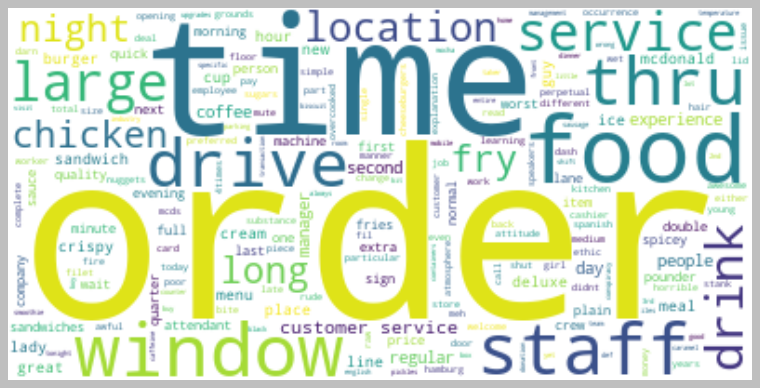

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ""
for aspect in all_aspects:
    text = text + " " + aspect
    

text = text.strip()

wordcloud = WordCloud(background_color='white').generate(text)
plt.style.use('classic')
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [35]:
asd

NameError: name 'asd' is not defined

In [36]:
# Preprocessing text
def preprocessing(text):
    text = remove_extra_spaces(text)
    text = expand_contractions(text)
    text = remove_non_ascii(text)
    return text

In [37]:
sentences = [
    "The cat can jump.",
    "The phone has a camera.",
    "Water can freeze.",
    "This car is fast.",
    "The sun gives light.",
    "The dog has sharp teeth.",
    "The computer can store data.",
    "My bike is lightweight.",
    "The wind can blow hard.",
    "Glass can break easily.",
    "The plant grows quickly.",
    "This material is waterproof.",
    "Birds can fly long distances.",
    "The phone charges wirelessly.",
    "This app automatically tracks your steps.",
    "The engine runs efficiently in cold weather.",
    "His voice carries across the room.",
    "Some animals can camouflage themselves.",
    "The robot is capable of learning new tasks.",
    "The building withstands strong earthquakes.",
    "This software adapts to user behavior over time.",
    "The bridge supports heavy loads without bending.",
    "The new processor processes data faster than previous models.",
    "These shoes reduce the impact on joints while running.",
    "The satellite transmits signals across continents.",
    "The medicine has anti-inflammatory properties.",
    "Solar panels convert sunlight into electricity efficiently.",
    "The AI system can predict stock market trends accurately.",
    "The genetic algorithm optimizes solutions for complex problems.",
    "The spacecraft is designed to sustain life for extended missions."
]


for s in sentences:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)

Sentence:  The cat can jump.
Sentence:  The phone has a camera.
Sentence:  Water can freeze.
Sentence:  This car is fast.
Sentence:  The sun gives light.
Sentence:  The dog has sharp teeth.
Sentence:  The computer can store data.
Sentence:  My bike is lightweight.
Sentence:  The wind can blow hard.
Sentence:  Glass can break easily.
Sentence:  The plant grows quickly.
Sentence:  This material is waterproof.
Sentence:  Birds can fly long distances.
Sentence:  The phone charges wirelessly.
Sentence:  This app automatically tracks your steps.
Sentence:  The engine runs efficiently in cold weather.
Sentence:  His voice carries across the room.
Sentence:  Some animals can camouflage themselves.
Sentence:  The robot is capable of learning new tasks.
Sentence:  The building withstands strong earthquakes.
Sentence:  This software adapts to user behavior over time.
Sentence:  The bridge supports heavy loads without bending.
Sentence:  The new processor processes data faster than previous models

In [38]:
neglected_sentences = [
    "The cat cannot jump.",
    "The phone doesn't have a camera.",
    "Water cannot freeze.",
    "This car is not fast.",
    "The sun doesn't give light.",
    "The dog doesn't have sharp teeth.",
    "The computer cannot store data.",
    "My bike is not lightweight.",
    "The wind cannot blow hard.",
    "Glass cannot break easily.",
    "The plant doesn't grow quickly.",
    "This material is not waterproof.",
    "Birds cannot fly long distances.",
    "The phone doesn't charge wirelessly.",
    "This app doesn't automatically track your steps.",
    "The engine doesn't run efficiently in cold weather.",
    "His voice doesn't carry across the room.",
    "Some animals cannot camouflage themselves.",
    "The robot is not capable of learning new tasks.",
    "The building doesn't withstand strong earthquakes.",
    "This software doesn't adapt to user behavior over time.",
    "The bridge doesn't support heavy loads without bending.",
    "The new processor doesn't process data faster than previous models.",
    "These shoes don't reduce the impact on joints while running.",
    "The satellite doesn't transmit signals across continents.",
    "The medicine doesn't have anti-inflammatory properties.",
    "Solar panels don't convert sunlight into electricity efficiently.",
    "The AI system cannot predict stock market trends accurately.",
    "The genetic algorithm doesn't optimize solutions for complex problems.",
    "The spacecraft is not designed to sustain life for extended missions."
]

for s in neglected_sentences:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)
    displacy.render(docex, 'dep')

Sentence:  The cat cannot jump.


Sentence:  The phone doesn't have a camera.


Sentence:  Water cannot freeze.


Sentence:  This car is not fast.


Sentence:  The sun doesn't give light.


Sentence:  The dog doesn't have sharp teeth.


Sentence:  The computer cannot store data.


Sentence:  My bike is not lightweight.


Sentence:  The wind cannot blow hard.


Sentence:  Glass cannot break easily.


Sentence:  The plant doesn't grow quickly.


Sentence:  This material is not waterproof.


Sentence:  Birds cannot fly long distances.


Sentence:  The phone doesn't charge wirelessly.


Sentence:  This app doesn't automatically track your steps.


Sentence:  The engine doesn't run efficiently in cold weather.


Sentence:  His voice doesn't carry across the room.


Sentence:  Some animals cannot camouflage themselves.


Sentence:  The robot is not capable of learning new tasks.


Sentence:  The building doesn't withstand strong earthquakes.


Sentence:  This software doesn't adapt to user behavior over time.


Sentence:  The bridge doesn't support heavy loads without bending.


Sentence:  The new processor doesn't process data faster than previous models.


Sentence:  These shoes don't reduce the impact on joints while running.


Sentence:  The satellite doesn't transmit signals across continents.


Sentence:  The medicine doesn't have anti-inflammatory properties.


Sentence:  Solar panels don't convert sunlight into electricity efficiently.


Sentence:  The AI system cannot predict stock market trends accurately.


Sentence:  The genetic algorithm doesn't optimize solutions for complex problems.


Sentence:  The spacecraft is not designed to sustain life for extended missions.


In [39]:
passive_sentences = [
    "The door is opened easily.",
    "The car is driven by many people.",
    "The package was delivered yesterday.",
    "The glass can be broken with a hammer.",
    "The lights are turned on automatically.",
    "The cake is baked in the oven.",
    "The window was cleaned this morning.",
    "The table is made of wood.",
    "The music is played softly.",
    "The email was sent last night.",
    "The car was repaired quickly.",
    "The movie was watched by millions.",
    "The test is graded electronically.",
    "The flowers are grown in a greenhouse.",
    "The room was decorated for the party.",
    "The document is stored in the cloud.",
    "The road was blocked by traffic.",
    "The password is encrypted for security.",
    "The project was completed ahead of schedule.",
    "The bridge is constructed to withstand earthquakes.",
    "The machine is programmed to operate autonomously.",
    "The software was updated to include new features.",
    "The building is powered by solar energy.",
    "The message was translated into several languages.",
    "The painting is admired by art enthusiasts.",
    "The data is analyzed by artificial intelligence.",
    "The system was designed to improve efficiency.",
    "The book was inspired by historical events.",
    "The device is charged wirelessly overnight.",
    "The spacecraft is equipped to explore distant planets."
]


for s in passive_sentences:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)
    displacy.render(docex, 'dep')

Sentence:  The door is opened easily.


Sentence:  The car is driven by many people.


Sentence:  The package was delivered yesterday.


Sentence:  The glass can be broken with a hammer.


Sentence:  The lights are turned on automatically.


Sentence:  The cake is baked in the oven.


Sentence:  The window was cleaned this morning.


Sentence:  The table is made of wood.


Sentence:  The music is played softly.


Sentence:  The email was sent last night.


Sentence:  The car was repaired quickly.


Sentence:  The movie was watched by millions.


Sentence:  The test is graded electronically.


Sentence:  The flowers are grown in a greenhouse.


Sentence:  The room was decorated for the party.


Sentence:  The document is stored in the cloud.


Sentence:  The road was blocked by traffic.


Sentence:  The password is encrypted for security.


Sentence:  The project was completed ahead of schedule.


Sentence:  The bridge is constructed to withstand earthquakes.


Sentence:  The machine is programmed to operate autonomously.


Sentence:  The software was updated to include new features.


Sentence:  The building is powered by solar energy.


Sentence:  The message was translated into several languages.


Sentence:  The painting is admired by art enthusiasts.


Sentence:  The data is analyzed by artificial intelligence.


Sentence:  The system was designed to improve efficiency.


Sentence:  The book was inspired by historical events.


Sentence:  The device is charged wirelessly overnight.


Sentence:  The spacecraft is equipped to explore distant planets.


In [40]:
negated_passive_sentences = [
    "The door is not opened easily.",
    "The car is not driven by many people.",
    "The package was not delivered yesterday.",
    "The glass cannot be broken with a hammer.",
    "The lights are not turned on automatically.",
    "The cake is not baked in the oven.",
    "The window was not cleaned this morning.",
    "The table is not made of wood.",
    "The music is not played softly.",
    "The email was not sent last night.",
    "The car was not repaired quickly.",
    "The movie was not watched by millions.",
    "The test is not graded electronically.",
    "The flowers are not grown in a greenhouse.",
    "The room was not decorated for the party.",
    "The document is not stored in the cloud.",
    "The road was not blocked by traffic.",
    "The password is not encrypted for security.",
    "The project was not completed ahead of schedule.",
    "The bridge is not constructed to withstand earthquakes.",
    "The machine is not programmed to operate autonomously.",
    "The software was not updated to include new features.",
    "The building is not powered by solar energy.",
    "The message was not translated into several languages.",
    "The painting is not admired by art enthusiasts.",
    "The data is not analyzed by artificial intelligence.",
    "The system was not designed to improve efficiency.",
    "The book was not inspired by historical events.",
    "The device is not charged wirelessly overnight.",
    "The spacecraft is not equipped to explore distant planets."
]

for s in negated_passive_sentences:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)
    displacy.render(docex, 'dep')

Sentence:  The door is not opened easily.


Sentence:  The car is not driven by many people.


Sentence:  The package was not delivered yesterday.


Sentence:  The glass cannot be broken with a hammer.


Sentence:  The lights are not turned on automatically.


Sentence:  The cake is not baked in the oven.


Sentence:  The window was not cleaned this morning.


Sentence:  The table is not made of wood.


Sentence:  The music is not played softly.


Sentence:  The email was not sent last night.


Sentence:  The car was not repaired quickly.


Sentence:  The movie was not watched by millions.


Sentence:  The test is not graded electronically.


Sentence:  The flowers are not grown in a greenhouse.


Sentence:  The room was not decorated for the party.


Sentence:  The document is not stored in the cloud.


Sentence:  The road was not blocked by traffic.


Sentence:  The password is not encrypted for security.


Sentence:  The project was not completed ahead of schedule.


Sentence:  The bridge is not constructed to withstand earthquakes.


Sentence:  The machine is not programmed to operate autonomously.


Sentence:  The software was not updated to include new features.


Sentence:  The building is not powered by solar energy.


Sentence:  The message was not translated into several languages.


Sentence:  The painting is not admired by art enthusiasts.


Sentence:  The data is not analyzed by artificial intelligence.


Sentence:  The system was not designed to improve efficiency.


Sentence:  The book was not inspired by historical events.


Sentence:  The device is not charged wirelessly overnight.


Sentence:  The spacecraft is not equipped to explore distant planets.


In [41]:
expressions = [
    "She cried.",
    "He smiled.",
    "They hugged.",
    "She laughed out loud.",
    "He frowned in confusion.",
    "They exchanged tears.",
    "She yelled in anger.",
    "He sighed with relief.",
    "They shared a nervous smile.",
    "She whispered her sadness.",
    "He shouted with joy.",
    "They held hands in comfort.",
    "She expressed her love with a kiss.",
    "He couldn't contain his excitement.",
    "They spoke quietly about their fears.",
    "She blushed when he complimented her.",
    "He admitted feeling overwhelmed.",
    "They shared a moment of silent grief.",
    "She told him she was heartbroken.",
    "He revealed his frustration to his family.",
    "They looked at each other with gratitude.",
    "She expressed her jealousy without words.",
    "He explained his disappointment in detail.",
    "They cried together, overwhelmed by emotions.",
    "She couldn't hide her anxiety about the future.",
    "He confessed his love after years of silence.",
    "They poured their hearts out in a late-night talk.",
    "She felt relief after finally expressing her fears.",
    "He struggled to share his vulnerability with friends.",
    "They opened up about their insecurities and bonded deeply."
]

for s in expressions:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)
    displacy.render(docex, 'dep')

Sentence:  She cried.


Sentence:  He smiled.


Sentence:  They hugged.


Sentence:  She laughed out loud.


Sentence:  He frowned in confusion.


Sentence:  They exchanged tears.


Sentence:  She yelled in anger.


Sentence:  He sighed with relief.


Sentence:  They shared a nervous smile.


Sentence:  She whispered her sadness.


Sentence:  He shouted with joy.


Sentence:  They held hands in comfort.


Sentence:  She expressed her love with a kiss.


Sentence:  He couldn't contain his excitement.


Sentence:  They spoke quietly about their fears.


Sentence:  She blushed when he complimented her.


Sentence:  He admitted feeling overwhelmed.


Sentence:  They shared a moment of silent grief.


Sentence:  She told him she was heartbroken.


Sentence:  He revealed his frustration to his family.


Sentence:  They looked at each other with gratitude.


Sentence:  She expressed her jealousy without words.


Sentence:  He explained his disappointment in detail.


Sentence:  They cried together, overwhelmed by emotions.


Sentence:  She couldn't hide her anxiety about the future.


Sentence:  He confessed his love after years of silence.


Sentence:  They poured their hearts out in a late-night talk.


Sentence:  She felt relief after finally expressing her fears.


Sentence:  He struggled to share his vulnerability with friends.


Sentence:  They opened up about their insecurities and bonded deeply.


In [42]:
conj_sentences = [
    "I wanted to go to the party, but I was too tired.",
    "She studied hard, so she passed the exam.",
    "Although it was raining, they went for a walk.",
    "He likes both pizza and pasta.",
    "You can have tea or coffee.",
    "I will call you when I arrive.",
    "If you need help, let me know.",
    "She was late because she missed the bus.",
    "He couldn’t decide whether to stay or leave.",
    "I’ll stay home unless the weather improves.",
    "She sings well, and she plays the piano beautifully.",
    "Since you’re here early, can you help me set up?",
    "We can leave now, or we can wait for him.",
    "I need to go shopping, but I have no time.",
    "I like cats, while my sister prefers dogs.",
    "He went to the gym so he could get fit.",
    "Although it was expensive, we bought the tickets.",
    "Before you leave, please check the oven.",
    "I was tired, yet I couldn’t sleep.",
    "We have to hurry, for the train is leaving soon.",
    "He wasn’t sure if he should go to the meeting.",
    "I can’t eat peanuts because I’m allergic to them.",
    "She’ll come over as soon as she finishes work.",
    "Even though it’s cold, I’m going for a run.",
    "He tried hard, but he didn’t succeed.",
    "You can take the bus, or you can walk.",
    "He hasn’t called, so I’m starting to worry.",
    "She wanted to stay home, but she went out anyway.",
    "Whether it rains or not, we’re going hiking.",
    "He loves playing video games, but he knows he needs to study more."
]

for s in conj_sentences:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)
    displacy.render(docex, 'dep')

Sentence:  I wanted to go to the party, but I was too tired.


Sentence:  She studied hard, so she passed the exam.


Sentence:  Although it was raining, they went for a walk.


Sentence:  He likes both pizza and pasta.


Sentence:  You can have tea or coffee.


Sentence:  I will call you when I arrive.


Sentence:  If you need help, let me know.


Sentence:  She was late because she missed the bus.


Sentence:  He couldn’t decide whether to stay or leave.


Sentence:  I’ll stay home unless the weather improves.


Sentence:  She sings well, and she plays the piano beautifully.


Sentence:  Since you’re here early, can you help me set up?


Sentence:  We can leave now, or we can wait for him.


Sentence:  I need to go shopping, but I have no time.


Sentence:  I like cats, while my sister prefers dogs.


Sentence:  He went to the gym so he could get fit.


Sentence:  Although it was expensive, we bought the tickets.


Sentence:  Before you leave, please check the oven.


Sentence:  I was tired, yet I couldn’t sleep.


Sentence:  We have to hurry, for the train is leaving soon.


Sentence:  He wasn’t sure if he should go to the meeting.


Sentence:  I can’t eat peanuts because I’m allergic to them.


Sentence:  She’ll come over as soon as she finishes work.


Sentence:  Even though it’s cold, I’m going for a run.


Sentence:  He tried hard, but he didn’t succeed.


Sentence:  You can take the bus, or you can walk.


Sentence:  He hasn’t called, so I’m starting to worry.


Sentence:  She wanted to stay home, but she went out anyway.


Sentence:  Whether it rains or not, we’re going hiking.


Sentence:  He loves playing video games, but he knows he needs to study more.


In [43]:
for s in conj_sentences:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)
    print(get_raw_abilities(docex))
    displacy.render(docex, 'dep')

# What is xcomp and acomp?


Sentence:  I wanted to go to the party, but I was too tired.
{0: [('the user', 'wanted'), ('the user', 'was tired')]}


Sentence:  She studied hard, so she passed the exam.
{0: []}


Sentence:  Although it was raining, they went for a walk.
{0: []}


Sentence:  He likes both pizza and pasta.
{0: []}


Sentence:  You can have tea or coffee.
{0: []}


Sentence:  I will call you when I arrive.
{0: [('the user', 'will call you'), ('the user', 'when arrive')]}


Sentence:  If you need help, let me know.
{0: [('the user', 'know')]}


Sentence:  She was late because she missed the bus.
{0: []}


Sentence:  He couldn’t decide whether to stay or leave.
{0: []}


Sentence:  I’ll stay home unless the weather improves.
{0: [('the user', '’ll stay home'), ('weather', 'improves')]}


Sentence:  She sings well, and she plays the piano beautifully.
{0: []}


Sentence:  Since you’re here early, can you help me set up?
{0: [('the user', 'set')]}


Sentence:  We can leave now, or we can wait for him.
{0: [('the user', 'can leave now'), ('the user', 'can wait')]}


Sentence:  I need to go shopping, but I have no time.
{0: [('the user', 'need'), ('the user', 'have time')]}


Sentence:  I like cats, while my sister prefers dogs.
{0: [('the user', 'like cats'), ('sister', 'prefers dogs')]}


Sentence:  He went to the gym so he could get fit.
{0: []}


Sentence:  Although it was expensive, we bought the tickets.
{0: [('the user', 'bought tickets')]}


Sentence:  Before you leave, please check the oven.
{0: []}


Sentence:  I was tired, yet I couldn’t sleep.
{0: [('the user', 'was tired'), ('the user', 'could not sleep')]}


Sentence:  We have to hurry, for the train is leaving soon.
{0: [('train', 'is leaving soon')]}


Sentence:  He wasn’t sure if he should go to the meeting.
{0: []}


Sentence:  I can’t eat peanuts because I’m allergic to them.
{0: [('the user', 'ca not eat peanuts')]}


Sentence:  She’ll come over as soon as she finishes work.
{0: []}


Sentence:  Even though it’s cold, I’m going for a run.
{0: [('the user', '’m going for run')]}


Sentence:  He tried hard, but he didn’t succeed.
{0: []}


Sentence:  You can take the bus, or you can walk.
{0: []}


Sentence:  He hasn’t called, so I’m starting to worry.
{0: [('the user', '’m starting')]}


Sentence:  She wanted to stay home, but she went out anyway.
{0: []}


Sentence:  Whether it rains or not, we’re going hiking.
{0: [('the user', '’re going')]}


Sentence:  He loves playing video games, but he knows he needs to study more.
{0: []}


In [71]:
sentences = [
    "The cat can jump.",
    "The phone has a camera.",
    "Water can freeze.",
    "This car is fast.",
    "The sun gives light.",
    "The dog has sharp teeth.",
    "The computer can store data.",
    "My bike is lightweight.",
    "The wind can blow hard.",
    "Glass can break easily.",
    "The plant grows quickly.",
    "This material is waterproof.",
    "Birds can fly long distances.",
    "The phone charges wirelessly.",
    "This app automatically tracks your steps.",
    "The engine runs efficiently in cold weather.",
    "His voice carries across the room.",
    "Some animals can camouflage themselves.",
    "The robot is capable of learning new tasks.",
    "The building withstands strong earthquakes.",
    "This software adapts to user behavior over time.",
    "The bridge supports heavy loads without bending.",
    "The new processor processes data faster than previous models.",
    "These shoes reduce the impact on joints while running.",
    "The satellite transmits signals across continents.",
    "The medicine has anti-inflammatory properties.",
    "Solar panels convert sunlight into electricity efficiently.",
    "The AI system can predict stock market trends accurately.",
    "The genetic algorithm optimizes solutions for complex problems.",
    "The spacecraft is designed to sustain life for extended missions."
]


for s in sentences:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)
    print(get_raw_abilities(docex))
    displacy.render(docex, 'dep')

Sentence:  The cat can jump.
{0: [('cat', 'can jump')]}


Sentence:  The phone has a camera.
{0: [('phone', 'has camera')]}


Sentence:  Water can freeze.
{0: [('water', 'can freeze')]}


Sentence:  This car is fast.
{0: [('car', 'is fast')]}


Sentence:  The sun gives light.
{0: [('sun', 'gives light')]}


Sentence:  The dog has sharp teeth.
{0: [('dog', 'has sharp teeth')]}


Sentence:  The computer can store data.
{0: [('computer', 'can store data')]}


Sentence:  My bike is lightweight.
{0: [('bike', 'is lightweight')]}


Sentence:  The wind can blow hard.
{0: [('wind', 'can blow hard')]}


Sentence:  Glass can break easily.
{0: [('Glass', 'can break easily')]}


Sentence:  The plant grows quickly.
{0: [('plant', 'grows quickly')]}


Sentence:  This material is waterproof.
{0: [('material', 'is waterproof')]}


Sentence:  Birds can fly long distances.
{0: [('bird', 'can fly long distances')]}


Sentence:  The phone charges wirelessly.
{0: []}


Sentence:  This app automatically tracks your steps.
{0: [('app', 'automatically tracks steps')]}


Sentence:  The engine runs efficiently in cold weather.
{0: [('engine', 'runs efficiently'), ('engine', 'runs in cold weather')]}


Sentence:  His voice carries across the room.
{0: [('voice', 'carries across room')]}


Sentence:  Some animals can camouflage themselves.
{0: [('animal', 'can camouflage themselves')]}


Sentence:  The robot is capable of learning new tasks.
{0: [('robot', 'is capable of learning new tasks')]}


Sentence:  The building withstands strong earthquakes.
{0: [('building', 'withstands strong earthquakes')]}


Sentence:  This software adapts to user behavior over time.
{0: [('software', 'adapts to behavior')]}


Sentence:  The bridge supports heavy loads without bending.
{0: [('bridge', 'supports without bending'), ('bridge', 'supports heavy loads')]}


Sentence:  The new processor processes data faster than previous models.
{0: [('processor', 'processes faster than previous models'), ('processor', 'processes data')]}


Sentence:  These shoes reduce the impact on joints while running.
{0: [('shoe', 'reduce impact')]}


Sentence:  The satellite transmits signals across continents.
{0: [('satellite', 'transmits across continents'), ('satellite', 'transmits signals')]}


Sentence:  The medicine has anti-inflammatory properties.
{0: [('medicine', 'has anti - inflammatory properties')]}


Sentence:  Solar panels convert sunlight into electricity efficiently.
{0: [('panel', 'convert efficiently'), ('panel', 'convert into electricity'), ('panel', 'convert sunlight')]}


Sentence:  The AI system can predict stock market trends accurately.
{0: [('system', 'can predict accurately'), ('system', 'can predict trends')]}


Sentence:  The genetic algorithm optimizes solutions for complex problems.
{0: [('algorithm', 'optimizes solutions')]}


Sentence:  The spacecraft is designed to sustain life for extended missions.
{0: [('spacecraft', 'is designed to sustain life')]}


In [45]:
# txt = 'I have no time, and money, but have house'
# txt = 'We have to hurry, for the train is leaving soon.'
txt = 'The bridge supports heavy loads without bending.'
docex = nlp(txt)
displacy.render(docex, 'dep')
get_raw_abilities(docex)

{0: [('bridge', 'supports heavy loads')]}

In [46]:
# 1. Add conjunct direct object (DONE)
# 2. Add xcomp after verb ==> Add preposition or adverb or adjective (the pattern similar like passive sentence case)
# 3. Store all possible verb conjunct and its index. It help re-looping unnecessary situation.
# 4. Is pre-positional adverb before verb necessary? (DONE) ==> Conjunct adverb is not needed.
# 5. I need to go shopping, but I have no time. ==> Check neglection in the rules (DONE)

In [65]:
def get_components_verb(verb):
    # Get auxiliary verb token
    aux = get_token_dep(verb, dep='aux')
    # Get direct object verb token
    obj = get_token_dep(verb, dep='dobj')
    # Get pre-modifier adverb 'string'
    advmod_left = get_token_dep_left(verb, dep=['advmod', 'npadvmod'])
    pre_adv = []
    if advmod_left:
        # Get pre and post adverb after pre main verb
        pre_advmod_left, post_advmod_left = extract_adv(advmod_left)
        pre_advmod_left = ' '.join(pre_advmod_left)
        post_advmod_left = ' '.join(post_advmod_left)
                
        pre_adv = [pre_advmod_left, advmod_left.text, post_advmod_left]
    pre_adv = (' '.join(pre_adv)).strip()

    # Get post-modifier adverb token
    advmod_right = get_token_dep_right(verb, dep=['advmod', 'npadvmod'])
    # Get preposition after verb token
    prep = get_token_dep(verb, dep='prep')
    
    return {'aux': aux, 'obj': obj, 'pre_adv': pre_adv, 'advmod': advmod_right, 'prep': prep}

def base_sentence(main_aux, main_verb, main_pre_adv, neg):
    # Concatenate components into: adv (optional) + verb
    ability = cross_product_str(main_pre_adv, main_verb.text)
    # Concatenate components into: not (optional) + adv (optional) + verb
    ability = cross_product_str(neg, ability)
    # If auxiliary token exist
    if main_aux:
        # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb
        ability = cross_product_str(main_aux.text, ability)
    return ability

def ability_advmod(advmod, **kwargs):
    # Get pre and post adverb after verb
    post_adv = []
    if advmod:
        # Get pre and post adverb after post main verb
        pre_advmod_right_main, post_advmod_right_main = extract_adv(advmod)
        pre_advmod_right_main = ' '.join(pre_advmod_right_main)
        post_advmod_right_main = ' '.join(post_advmod_right_main)

        post_adv = [pre_advmod_right_main, advmod.text, post_advmod_right_main]
        
    post_adv = (' '.join(post_adv)).strip()
    # Get preposition after adverb
    prep_after_advmod = crawling_after_token_prep_phrase(advmod)

    # Concatenate components: aux (optional) + not (optional) + adv (optional) + verb
    ability = base_sentence(main_aux=kwargs['main_aux'],
                            main_verb=kwargs['main_verb'],
                            main_pre_adv=kwargs['main_pre_adv'], 
                            neg=kwargs['neg'])
    # Concatenate components: aux (optional) + not (optional) + adv (optional) + verb + adv
    ability = cross_product_str(ability, post_adv)
    # If preposition after adverb exist
    if prep_after_advmod:
        # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb + adv + preposition phrase (optional)
        ability = cross_product_str(ability, prep_after_advmod)
                    
    # EXPECTED PATTERN: Subject + aux (optional) + not (optional) + adv (optional) + verb + adv + prepositional phrase (optional)
    return ability

def ability_dobj(obj, neglect=False, **kwargs):
    temp = []
    # If the neglection does not appear as children's verb
    if neglect:
        neg = get_neglect(obj)
        kwargs['neg'] = neg
    # Get pre adjectvie modifier of object
    pre_adj = ' '.join(extract_pre_adj(obj))

    # Concatenate components: aux (optional) + not (optional) + adv (optional) + verb
    ability = base_sentence(main_aux=kwargs['main_aux'],
                            main_verb=kwargs['main_verb'],
                            main_pre_adv=kwargs['main_pre_adv'], 
                            neg=kwargs['neg'])
    # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb + adj (optional)
    ability = cross_product_str(ability, pre_adj)
    # Concatenate components into: aux (optional) + not (optional) + adv (optional) + verb + adj (optional) + Direct object
    ability = cross_product_str(ability, obj.text)

    temp += ability

    #====== Conjunct Object =======#
    obj_conjunct = extract_conj(obj)
    if len(obj_conjunct) > 0:
        # Concatenate components into: Verb (Have) + Conjunct
        ability = cross_product_str(head.text, obj_conjunct)
        # Concatenate components into: not (optional) + Verb (Have) + Conjunct
        ability = cross_product_str(neg, ability)
    
        # Add the ability into abilities
        temp += ability
        # EXPECTED PATTERN: Subject + not (optional) + Verb (Have) + Direct object
        # Note: Since normaly, If direct object is noun/propn/pron the conjuncts are noun/propn/pron too.
        #        This rule follow this concept. In somehow, the conjunct could be adjective or another verb.

    return temp

def ability_prep(prep, neglect=False, **kwargs):
    # Get object of preposition
    obj = get_token_dep_right(prep, dep=['dobj', 'pobj'])
    pcomp = None
    # If object does not exist
    if not obj:
        # Get the preposition complement
        pcomp = get_token_dep_right(prep, dep='pcomp')
        # Get the object that refers to preposition complement
        obj = get_token_dep_right(pcomp, dep=['dobj', 'pobj'])

    # If the neglection does not appear as children's verb, 
    #   try catch neglection in front object.
    if neglect:
        neg = get_neglect(obj)
        # Update value
        kwargs['neg'] = neg

    # Concatenate components: aux (optional) + not (optional) + adv (optional) + verb
    ability = base_sentence(main_aux=kwargs['main_aux'],
                            main_verb=kwargs['main_verb'],
                            main_pre_adv=kwargs['main_pre_adv'], 
                            neg=kwargs['neg'])
    # Concatenate components: aux (optional) + not (optional) + adv (optional) + verb + preposition
    ability = cross_product_str(ability, prep.text)
    # If preposition compliment or object exist
    if (pcomp) or (obj):
        # If preposition compliment exist
        if pcomp:
        # Concatenate components: aux (optional) + not (optional) + adv (optional) 
        #                           + verb + preposition + preposition-compliment (optional)
            ability = cross_product_str(ability, pcomp.text)
        # Concatenate components: aux (optional) + not (optional) + adv (optional) 
        #                           + verb + preposition + preposition-compliment (optional)
        #                           + pre adjective (optional) 
        # If object exist
        if obj:
            # Get pre adjective modifier object
            pre_adj = ' '.join(extract_pre_adj(obj))
            ability = cross_product_str(ability, pre_adj)
            # Concatenate components: aux (optional) + not (optional) + adv (optional) 
            #                           + verb + preposition + preposition-compliment (optional)
            #                           + pre adjective (optional) + object (optional)
            ability = cross_product_str(ability, obj.text)
        return ability
    
    return []

In [66]:
###======== COMPONENTS COMPLIMENTS RULES ===============####

def get_components_comp(comp):
    if not comp:
        return

    # Get auxiliary verb of clausal complement token
    aux = get_token_dep(comp, dep='aux')
    # Get direct object of clausal complement token
    obj = get_token_dep(comp, dep='dobj')
    # Get adverb modifier of clausal complement token
    advmod = get_token_dep(comp, dep='advmod')
    # Get preposition after clausal complement token
    prep = get_token_dep_right(comp, dep='prep')
    # Get adjectival complement of clausal complement token
    acomp = get_token_dep_right(comp, dep='acomp') or get_token_pos_right(comp, pos='ADJ')

    return {'aux': aux, 'obj': obj, 'advmod': advmod, 'prep': prep, 'acomp': acomp}


def base_sentence_comp(comp, **kwargs):
    # Generate base sentence: aux (optional) + not (optional) + adv (optional) + verb
    ability = base_sentence(main_aux=kwargs['main_aux'],
                            main_verb=kwargs['main_verb'],
                            main_pre_adv=kwargs['main_pre_adv'], 
                            neg=kwargs['neg'])
    if kwargs['aux_comp']:
        # Concatenate components: aux (optional) + not (optional) + adv (optional) 
        #                           + verb + aux-comp (optional)
        ability = cross_product_str(ability, kwargs['aux_comp'].text)
    # Concatenate components: aux (optional) + not (optional) + adv (optional) 
    #                           + verb + aux-comp (optional) + compliment
    ability = cross_product_str(ability, comp.text)
    
    return ability
    
def ability_comp_dobj(comp, obj, neglect=False, **kwargs):
    # If the neglection do not appear as children's verb, 
    #   try catch neglection in front object.
    
    if neglect:
        neg = get_neglect(obj)
    # Get pre adjective modifier of direct object and convert in into string
    pre_adj = ' '.join(extract_pre_adj(obj))
    
    # Concatenate components: aux (optional) + not (optional) + adv (optional) 
    #                           + verb + aux-comp (optional) + compliment
    ability = base_sentence_comp(comp, **kwargs)
    # Concatenate components: aux (optional) + not (optional) + adv (optional) 
    #                           + verb + aux-comp (optional) + compliment
    #                           + pre-adj-obj (optional)
    ability = cross_product_str(ability, pre_adj)
    # Concatenate components: aux (optional) + not (optional) + adv (optional) 
    #                           + verb + aux-comp (optional) + compliment
    #                           + pre-adj-dobj (optional) + direct object
    ability = cross_product_str(ability, obj.text)
    return ability

def ability_comp_advmod(comp, advmod, **kwargs):
    # Get pre and post adverb of main adverb modifier compliment.
    pre_advmod, post_advmod = extract_adv(advmod)
    pre_advmod = ' '.join(pre_advmod)
    post_advmod = ' '.join(post_advmod)

    # Concatenate components: aux (optional) + not (optional) + adv (optional) + verb 
    #                           + aux-aux-comp (optional) + compliment
    ability = base_sentence_comp(comp, **kwargs)
    # Concatenate components: aux (optional) + not (optional) + adv (optional) + verb 
    #                           + aux-comp (optional) + compliment + pre-adverb
    ability = cross_product_str(ability, pre_advmod)
    # Concatenate components: aux (optional) + not (optional) + adv (optional) + verb 
    #                           + aux-comp (optional) + compliment + pre-adverb mod + advmod
    ability = cross_product_str(ability, advmod.text)
    # Concatenate components: aux (optional) + not (optional) + adv (optional) + verb 
    #                           + aux-comp (optional) + compliment + pre-adverb modifier
    #                           + advmod + post-adverb modifier
    ability = cross_product_str(ability, post_advmod)

    return ability

def ability_comp_acomp(comp, acomp, **kwargs):
    # If the neglection do not appear as children's verb, 
    #   try catch neglection in front object.
    
    # Concatenate components: aux (optional) + not (optional) + adv (optional) 
    #                           + verb + aux-comp (optional) + compliment
    ability = base_sentence_comp(comp, **kwargs)
    # Concatenate components: aux (optional) + not (optional) + adv (optional) 
    #                           + verb + aux-comp (optional) + compliment
    #                           + adjectival complement
    ability = cross_product_str(ability, acomp.text)
    return ability

def ability_comp_prep(comp, prep, neglect=False, **kwargs):
    # Get object of preposition
    obj = get_token_dep_right(prep, dep=['dobj', 'pobj'])
    pcomp = None
    # If object does not exist
    if not obj:
        # Get the preposition complement
        pcomp = get_token_dep_right(prep, dep='pcomp')
        # Get the object that refers to preposition complement
        obj = get_token_dep_right(pcomp, dep=['dobj', 'pobj'])

    # If the neglection does not appear as children's verb, 
    #   try catch neglection in front object.
    if neglect:
        neg = get_neglect(obj)
        # Update value
        kwargs['neg'] = neg

    # Concatenate components: aux (optional) + not (optional) + adv (optional) 
    #                           + verb + aux-comp (optional) + compliment
    ability = base_sentence_comp(comp, **kwargs)
    # If preposition compliment exist
    if pcomp:
    # Concatenate components: aux (optional) + not (optional) + adv (optional) 
    #                           + verb + aux-comp (optional) + compliment + prep-compliment
        ability = cross_product_str(ability, pcomp.text)
    # Concatenate components: aux (optional) + not (optional) + adv (optional) 
    #                           + verb + aux-comp (optional) + compliment + prep-compliment
    #                           + pre adjective  
    if obj:
        # Get pre adjective modifier object
        pre_adj = ' '.join(extract_pre_adj(obj))        
        ability = cross_product_str(ability, pre_adj)
        # Concatenate components: aux (optional) + not (optional) + adv (optional) 
        #                           + verb + aux-comp (optional) + compliment + prep-compliment
        #                           + pre adjective + object
        ability = cross_product_str(ability, obj.text)
    return ability

In [73]:
###============ AUXILIARY ================###

def ability_aux_adj(adj, **kwargs):
    # Get Preposition after adjective
    # prep_after_adj = ' '.join(crawling_after_token_prep_phrase(adj_token))

    # Generate base sentence: aux + not (optional)
    ability = base_sentence(main_aux=kwargs['main_aux'],
                            main_verb=kwargs['main_verb'],
                            main_pre_adv=kwargs['main_pre_adv'], 
                            neg=kwargs['neg'])
    # Concatenate components into: aux + not (optional) + adj
    ability = cross_product_str(ability, adj.text)

    # GET PREPOSITION AFTER ADJ
    # ability = cross_product_str(ability, prep_after_adj)

    # GET CONJUNCT
    return ability

def ability_aux_noun(noun, **kwargs):
    # Get pre-modifier adjective of noun
    pre_adj = ' '.join(extract_pre_adj(noun))
    # Generate base sentence: aux + not (optional)
    ability = base_sentence(main_aux=kwargs['main_aux'],
                            main_verb=kwargs['main_verb'],
                            main_pre_adv=kwargs['main_pre_adv'], 
                            neg=kwargs['neg'])
    # Concatenate components into: aux + not (optional) + pre-modifier adjective (optional)
    ability = cross_product_str(ability, pre_adj)
    # Concatenate components into: aux + not (optional) + pre-modifier adjective (optional) + noun
    ability = cross_product_str(ability, noun.text)
    return ability

In [72]:
# 1. Add conjunct direct object (DONE)
# 2. Add xcomp after verb ==> Add preposition or adverb or adjective (the pattern similar like passive sentence case)
# 3. Store all possible verb conjunct and its index. It help re-looping unnecessary situation.
# 4. Is pre-positional adverb before verb necessary? (DONE) ==> Conjunct adverb is not needed.
# 5. I need to go shopping, but I have no time. ==> Check neglection in the rules (DONE)

def subject_active_rules(token):
    abilities = []
    # Go to its head
    head = token.head

    # Get neglect; If there is no neglect, return empty text.
    neg = get_neglect(head)

    # If head is Verb.
    if head.pos_ == 'VERB':

        # Get all conjunct (except adjective with dependency acomp)
        if neg:
            verb_conjunct = extract_conj(head)
        else:
            # If neglect do not come at first, then check neglection in front each conjunct.
            verb_conjunct = extract_conj(head, neglect=True)

        ###============ GET ALL TOKENS ================###
        aux, obj, pre_adv, advmod_right, prep = get_components_verb(head).values()
            
        # Get intransitive rate score
        int_rate = map_verb_intrans.get(head.text) or map_verb_intrans.get(head.lemma_)
        # If the verb is not in the mapper ( we assume it is transitive verb )
        if not int_rate:
            int_rate = 0

        #==================== COMPLIMENT ========================#
        # Get ccomp (VERB) token
        ccomp = get_token_dep(head, dep='ccomp')
        # If the ccomp not exist and the VERB pos tag or contain auxiliary passive
        if ccomp and (ccomp.pos_ != 'VERB' or get_token_dep(ccomp, dep='auxpass')):
            ccomp = None
        elif ccomp:
            aux_ccomp, obj_ccomp, advmod_ccomp, prep_ccomp, acomp_ccomp = get_components_comp(ccomp).values()
            
            # Get intransitive rate score
            int_rate_ccomp = map_verb_intrans.get(head.text) or map_verb_intrans.get(head.lemma_)
            # If the verb is not in the mapper ( we assume it is transitive verb )
            if not int_rate_ccomp:
                int_rate_ccomp = 0

        # Get xcomp token
        xcomp = get_token_dep(head, dep='xcomp')

        if xcomp:
            aux_xcomp, obj_xcomp, advmod_xcomp, prep_xcomp, acomp_xcomp = get_components_comp(xcomp).values()
        # Get intransitive rate score
        int_rate_xcomp = map_verb_intrans.get(head.text) or map_verb_intrans.get(head.lemma_)
        # If the verb is not in the mapper ( we assume it is transitive verb )
        if not int_rate_xcomp:
            int_rate_xcomp = 0



        ###===================== CONDITION =====================###

        components = {'main_aux': aux, 'main_verb': head, 'main_pre_adv': pre_adv,
                               'neg': neg, }
        if (advmod_right) or (prep) or (obj) or (xcomp):
            # If adverb after verb exist ==> Subject + aux (optional) + not (optional) + adv (optional) + verb + adv + preposition phrase (optional)
            if advmod_right:
                ability = ability_advmod(advmod=advmod_right, **components)
                # EXPECTED PATTERN: Subject + aux (optional) + not (optional) + adv (optional) + verb + adv + prepositional phrase (optional)
                abilities += ability

            # If prep after verb ==> Subject + aux (optional) + not (optional) + adv (optional) + verb + preposition phrase
            if prep:
                ability = ability_prep(prep, **components)
    
                # EXPECTED PATTERN: Subject + aux (optional) + not (optional) + adv (optional) + verb + preposition phrase
                abilities += ability

            # If direct object exist ==> Subject + aux (optional) + not (optional) + adv (optional) + verb + adj (optional) + Direct object
            if obj:
                ability = ability_dobj(obj, **components)
                abilities += ability
                
            if xcomp:
                components['aux_comp'] = aux_xcomp
            
                if (obj_xcomp) or (advmod_xcomp) or (prep_xcomp) or (acomp_xcomp):
        
                    # If direct object exist
                    if obj_xcomp:                    
                        ability = ability_comp_dobj(comp=xcomp, obj=obj_xcomp, neglect=False, **components)
                        abilities += ability
            
                    # If advmod exist
                    if advmod_xcomp:
                        ability = ability_comp_advmod(comp=xcomp, advmod=advmod_xcomp, **components)
                        abilities += ability
    
                    # If preposition after xcomp appears
                    if prep_xcomp:
                        ability = ability_comp_prep(comp=xcomp, prep=prep_xcomp, **components)                    
                        abilities += ability
        
                    # If acomp after xcomp appears
                    if acomp_xcomp:
                        ability = ability_comp_acomp(comp=xcomp, acomp=acomp_xcomp, **components)
                        abilities += ability
                
                else:
                    # If do not contain any of that, but intransitive verb ==> Subject + aux (optional) + not (optional) + adv (optional) + verb
                    if int_rate_xcomp > 0.5:
                        ability = base_sentence_comp(comp=xcomp, **components)
                        # EXPECTED PATTERN: aux (optional) + not (optional) + adv (optional) + verb
                        abilities += ability
                 

            if ccomp: 
                components['aux_comp'] = aux_ccomp
                if (obj_ccomp) or (advmod_ccomp) or (prep_ccomp) or (acomp_ccomp):    
                    # If direct object exist
                    if obj_ccomp:
                        ability = ability_comp_dobj(comp=ccomp, obj=obj_ccomp, neglect=False, **components)
                        abilities += ability
                    # If advmod exist
                    if advmod_ccomp:
                        ability = ability_comp_advmod(comp=ccomp, advmod=advmod_ccomp, **components)
                        abilities += ability         
                    # If preposition after ccomp appears
                    if prep_ccomp:
                        ability = ability_comp_prep(comp=ccomp, prep=prep_ccomp, **components)                    
                        # TRY TO ADD OTHER CONJUNCTS HERE #
                        abilities += ability
                    # If acomp after xcomp appears
                    if acomp_ccomp:
                        ability = ability_comp_acomp(comp=ccomp, acomp=acomp_ccomp, **components)
                        abilities += ability           
                else:
                    # If do not contain any of that, but intransitive verb ==> Subject + aux (optional) + not (optional) + adv (optional) + verb
                    if int_rate_ccomp > 0.5:
                        ability = base_sentence_comp(comp=ccomp, **components)
                        # EXPECTED PATTERN: aux (optional) + not (optional) + adv (optional) + verb
                        abilities += ability

        else:
            # If do not contain any of that, but intransitive verb ==> Subject + aux (optional) + not (optional) + adv (optional) + verb
            if int_rate > 0.5:
                ability = base_sentence(**components)
                # EXPECTED PATTERN: aux (optional) + not (optional) + adv (optional) + verb
                abilities += ability

    # If head is aux
    elif head.pos_ == 'AUX':
        # Get the token
        # NOTE: if 'AUX' is root, only have one adjective with dependency acomp.
        adj = get_token_dep(head, dep='acomp')
        noun = get_token_pos_right(head, pos=['NOUN', 'PROPN'])

        if adj:
            ability = adj_token(adj, **components)
            # EXPECTED PATTERN: Subject + aux + not (optional) + adj
            abilities += ability


        elif noun:
            ability = ability_aux_noun(noun, **components)
            # EXPECTED PATTERN: Subject + aux + not (optional) + pre-modifier adjective (optional) + noun
            abilities += ability
    return abilities

In [68]:
def get_raw_abilities(doc, ant_first_pron='the user'):
    # Define local variable.
    storage = {}
    first_person_pronouns = [ 'i', 'me', 'my', 'mine', 'we', 'us', 'our', 'ours']
    pronouns = [
    "he", "she", "they", "it", # Personal Pronouns (Subjective)
    "him", "her", "them", "it", "you",  # Personal Pronouns (Objective)
    "his", "hers", "theirs", "its", "mine", "yours", "ours",  # Possessive Pronouns
    "her", "their", "its",  # Possessive Adjectives
    "himself", "herself", "themself", "themselves", "Itself",  # Reflexive Pronouns,
    "this", "that", "these", "those", # Demonstrative Pronouns
    "who", "whom", "whose", "which", "that"  # Relative Pronouns
    ]


    # Get sentence mapper and prepare storage
    sentence_points = {}
    for i, s in enumerate(doc.sents):
        sentence_points[i] = (s.start, s.end)
        storage[i] = []

    # Get mapper pronoun and antecedents
    mapper_pron_ant = get_mapper_pron_ant(doc)

    # Define local variable.
    result = []
    for idx, token in enumerate(doc):
        abilities = []

        ## ==================== SUBJECT ACTIVE SENTENCE =========================== ##
        # If token is subject (should be nsubj and nsubjpass). This time only nsubj
        # In case active sentence form
        if token.dep_ == 'nsubj':
            abilities += subject_active_rules(token)

        ## ==================== SUBJECT PASSIVE SENTENCE =========================== ##
        # If sentence is passive form.
        if token.dep_ == 'nsubjpass':
            abilities += subject_passive_rules(token)
                
        # Store final result
        if len(abilities) > 0:
            # Subject handling
            subject = token.lemma_
            # current_idx = token.i
            # If the subject is pronouns and first person pronouns
            # if token.pos_ == 'PRON' and token.text.lower() in first_person_pronouns:
            #     subject = ant_first_pron
            # # If subject is pronouns and its token location in mapper_pron_ant
            # elif token.pos_ == 'PRON' and idx in mapper_pron_ant.keys():
            #     # Get the antecedent index location
            #     idx_map = mapper_pron_ant[idx]
            #     # Change current token subject
            #     token = doc[idx_map]
            #     subject = token.lemma_
            # # If the current child is pronoun (but not in mapper_pron_ant keys)
            # elif token.pos_ == 'PRON' and token.text.lower() in pronouns:
            #     continue
            # # If token only contains special characters or numbers, or length text less than 3 (NOT PRONOUNS)
            # elif (re.match(r'^[0-9\W]+$', token.text)) or (len(token.text) < 3):
            #     continue
                
            # Get all conj subject + current subject
            subjects = [subject] + extract_conj(token)
            # # Store result
            # result += cross_product_tuple(subjects, abilities)
            # Storage final result
            sentence_location = get_sentence_location(sentence_points, idx)
            storage[sentence_location] += cross_product_tuple(subjects, abilities)

    # Storing final result
    return storage

In [51]:
map_verb_intrans.get("wants")

# Bug:
# - They hugged
# - She yelled in anger.
# - He frowned in confusion.
# - They held hands in comfort.
# (1) Fix filter (2) Fix conditional of verb, preposition

0.8799334412664148

In [52]:
# Simple sentences
xcomp_sentences = [
    "She wants to go to the party.",
    "I tried to finish my work early.",
    "He seems to be tired.",
    "They asked me to help them.",
    "She chose to stay home.",
    "He began to read the book.",
    "I need to buy some groceries.",
    "They promised to visit us soon.",
    "She started to cry after hearing the news.",
    "He decided to move to a new city.",
    "She told him to call later.",
    "I expect you to finish the project by tomorrow.",
    "We hope to see you soon.",
    "She refused to answer the question.",
    "I plan to travel next summer.",
    "He forgot to lock the door.",
    "They seem to know each other.",
    "I asked her to bring the documents.",
    "She tried to explain her idea.",
    "They agreed to participate in the event.",
    "I want to learn a new language.",
    "He decided to quit his job.",
    "She begged him to stay.",
    "I hope to meet you soon.",
    "They planned to launch the product next month.",
    "She forgot to send the email.",
    "He appears to be happy.",
    "They demanded him to resign.",
    "She allowed them to leave early.",
    "I wish to improve my skills.",
    "She expressed her desire to go to the party.",
    "I made an effort to finish my work early.",
    "It seems as though he is tired.",
    "They requested me to assist them in the task.",
    "She made the decision to stay home.",
    "He commenced reading the book as planned.",
    "I find it necessary to purchase some groceries.",
    "They gave their word that they would visit us soon.",
    "She began to weep after hearing the distressing news.",
    "He made the decision to relocate to a new city.",
    "She instructed him to make a call later.",
    "I anticipate that you will complete the project by tomorrow.",
    "We are hopeful that we will see you soon.",
    "She denied the request to answer the question.",
    "I have the intention to travel next summer.",
    "He neglected to secure the door.",
    "It appears that they are acquainted with each other.",
    "I made a request for her to bring the necessary documents.",
    "She made an attempt to explain her complex idea.",
    "They reached an agreement to take part in the event.",
    "I have a desire to acquire a new language.",
    "He made the decision to terminate his employment.",
    "She implored him to remain with her.",
    "I am hopeful that we will meet soon.",
    "They scheduled the launch of the product for next month.",
    "She neglected to send the important email.",
    "It appears that he is content.",
    "They issued a demand for his resignation.",
    "She granted them permission to leave early.",
    "I have the aspiration to enhance my skills."
]


for s in xcomp_sentences:
    print("Sentence: ", s)
    sample = s
    docex = nlp(sample)
    displacy.render(docex, 'dep')
    print(get_raw_abilities(docex))


Sentence:  She wants to go to the party.


{0: [('she', 'wants to go party')]}
Sentence:  I tried to finish my work early.


{0: [('I', 'tried to finish work'), ('I', 'tried to finish early')]}
Sentence:  He seems to be tired.


{0: [('he', 'seems to be tired')]}
Sentence:  They asked me to help them.


{0: [('they', 'asked me'), ('they', 'asked to help them')]}
Sentence:  She chose to stay home.


{0: [('she', 'chose to stay home')]}
Sentence:  He began to read the book.


{0: [('he', 'began to read book')]}
Sentence:  I need to buy some groceries.


{0: [('I', 'need to buy groceries')]}
Sentence:  They promised to visit us soon.


{0: [('they', 'promised to visit us'), ('they', 'promised to visit soon')]}
Sentence:  She started to cry after hearing the news.


{0: [('she', 'started to cry hearing news')]}
Sentence:  He decided to move to a new city.


{0: [('he', 'decided to move new city')]}
Sentence:  She told him to call later.


{0: [('she', 'told him'), ('she', 'told to call later')]}
Sentence:  I expect you to finish the project by tomorrow.


{0: [('I', 'expect'), ('you', 'to finish by tomorrow'), ('you', 'to finish project')]}
Sentence:  We hope to see you soon.


{0: [('we', 'hope to see you'), ('we', 'hope to see soon')]}
Sentence:  She refused to answer the question.


{0: [('she', 'refused to answer question')]}
Sentence:  I plan to travel next summer.


{0: [('I', 'plan to travel')]}
Sentence:  He forgot to lock the door.


{0: [('he', 'forgot to lock door')]}
Sentence:  They seem to know each other.


{0: [('they', 'seem to know other'), ('they', 'seem to know other')]}
Sentence:  I asked her to bring the documents.


{0: [('I', 'asked her'), ('I', 'asked to bring documents')]}
Sentence:  She tried to explain her idea.


{0: [('she', 'tried to explain idea')]}
Sentence:  They agreed to participate in the event.


{0: [('they', 'agreed to participate event')]}
Sentence:  I want to learn a new language.


{0: [('I', 'want to learn new language')]}
Sentence:  He decided to quit his job.


{0: [('he', 'decided to quit job')]}
Sentence:  She begged him to stay.


{0: [('she', 'begged him'), ('she', 'begged to stay')]}
Sentence:  I hope to meet you soon.


{0: [('I', 'hope to meet you'), ('I', 'hope to meet soon')]}
Sentence:  They planned to launch the product next month.


{0: [('they', 'planned to launch product')]}
Sentence:  She forgot to send the email.


{0: [('she', 'forgot to send email')]}
Sentence:  He appears to be happy.


{0: [('he', 'appears to be happy')]}
Sentence:  They demanded him to resign.


{0: [('they', 'demanded'), ('he', 'to resign')]}
Sentence:  She allowed them to leave early.


{0: [('she', 'allowed'), ('they', 'to leave early')]}
Sentence:  I wish to improve my skills.


{0: [('I', 'wish to improve skills')]}
Sentence:  She expressed her desire to go to the party.


{0: [('she', 'expressed desire')]}
Sentence:  I made an effort to finish my work early.


{0: [('I', 'made effort')]}
Sentence:  It seems as though he is tired.


{0: [('it', 'seems'), ('he', 'is tired')]}
Sentence:  They requested me to assist them in the task.


{0: [('they', 'requested me'), ('they', 'requested to assist them'), ('they', 'requested to assist task')]}
Sentence:  She made the decision to stay home.


{0: [('she', 'made decision')]}
Sentence:  He commenced reading the book as planned.


{0: [('he', 'commenced reading book')]}
Sentence:  I find it necessary to purchase some groceries.


{0: []}
Sentence:  They gave their word that they would visit us soon.


{0: [('they', 'gave word'), ('they', 'would visit soon'), ('they', 'would visit us')]}
Sentence:  She began to weep after hearing the distressing news.


{0: [('she', 'began to weep hearing news')]}
Sentence:  He made the decision to relocate to a new city.


{0: [('he', 'made decision')]}
Sentence:  She instructed him to make a call later.


{0: [('she', 'instructed him'), ('she', 'instructed to make call'), ('she', 'instructed to make later')]}
Sentence:  I anticipate that you will complete the project by tomorrow.


{0: [('you', 'will complete by tomorrow'), ('you', 'will complete project')]}
Sentence:  We are hopeful that we will see you soon.


{0: [('we', 'are hopeful'), ('we', 'will see soon'), ('we', 'will see you')]}
Sentence:  She denied the request to answer the question.


{0: [('she', 'denied request')]}
Sentence:  I have the intention to travel next summer.


{0: [('I', 'have intention')]}
Sentence:  He neglected to secure the door.


{0: [('he', 'neglected to secure door')]}
Sentence:  It appears that they are acquainted with each other.


{0: [('it', 'appears'), ('they', 'are acquainted with other')]}
Sentence:  I made a request for her to bring the necessary documents.


{0: [('I', 'made request'), ('she', 'to bring necessary documents')]}
Sentence:  She made an attempt to explain her complex idea.


{0: [('she', 'made attempt')]}
Sentence:  They reached an agreement to take part in the event.


{0: [('they', 'reached agreement')]}
Sentence:  I have a desire to acquire a new language.


{0: [('I', 'have desire')]}
Sentence:  He made the decision to terminate his employment.


{0: [('he', 'made decision')]}
Sentence:  She implored him to remain with her.


{0: [('she', 'implored him'), ('she', 'implored to remain her')]}
Sentence:  I am hopeful that we will meet soon.


{0: [('I', 'am hopeful'), ('we', 'will meet soon')]}
Sentence:  They scheduled the launch of the product for next month.


{0: [('they', 'scheduled for next month'), ('they', 'scheduled launch')]}
Sentence:  She neglected to send the important email.


{0: [('she', 'neglected to send important email')]}
Sentence:  It appears that he is content.


{0: [('it', 'appears'), ('he', 'is content')]}
Sentence:  They issued a demand for his resignation.


{0: [('they', 'issued demand')]}
Sentence:  She granted them permission to leave early.


{0: [('she', 'granted permission')]}
Sentence:  I have the aspiration to enhance my skills.


{0: [('I', 'have aspiration')]}


In [53]:
# Pattern 
# 0. aux-xcomp + xcomp (I think it is inf verb): stay, travel
# 1. aux-xcomp + xcomp + advmod
# 2. aux-xcomp + xcomp + dobj
# 3. aux-xcomp + xcomp + acomp (ADJ)
# 4. aux-xcomp + xcomp + prep + pcomp + dobj
# 5. aux-xcomp + xcomp + prep + pobj

# NOTE ccomp is verb not ADJ and ccomp is do not have auxpass (not in passive form)
# 6. aux-xcomp + ccomp + prep + pobj
# 7. aux-xcomp + ccomp + dobj
# 8. aux-xcomp + ccomp + advmod
# 9. ccomp + aux-advcl + advcl + dobj (NOT SURE)

# NOTE acl is verb (after noun)
# 9. aux-acl + acl (after noun) +  prep + pobj
# 10. aux-acl + acl + dobj
# 11. aux-acl + acl + advmod

# 12. aux-advcl + advcl + dobj
# 13. 


# NOTE:
# - Should the verb head is not ccomp or xcomp
# - Pre adjective object must be added
# - After object check is there any preposition


In [54]:
# txt = "She made the decision to eat rice."
txt = "He commenced reading the book as planned."

docex = nlp(txt)
displacy.render(docex, 'dep')
print(get_raw_abilities(docex))

{0: [('he', 'commenced reading book')]}


In [55]:
def subject_active_rules(token):
    abilities = []
    # Go to its head
    head = token.head

    # Get neglect; If there is no neglect, return empty text.
    neg = get_neglect(head)

    # If head is Verb.
    if head.pos_ == 'VERB':

        # Get all conjunct (except adjective with dependency acomp)
        if neg:
            verb_conjunct = extract_conj(head)
        else:
            # If neglect do not come at first, then check neglection in front each conjunct.
            verb_conjunct = extract_conj(head, neglect=True)

        ###============ GET ALL TOKENS ================###
        # Get aux
        aux = get_token_dep(head, dep='aux')
            
        # Get pre and post adverb after verb
        advmod_right_main = get_token_dep_right(head, dep=['advmod', 'npadvmod'])
        post_adv = []
        if advmod_right_main:
            # Get pre and post adverb after post main verb
            pre_advmod_right_main, post_advmod_right_main = extract_adv(advmod_right_main)
            pre_advmod_right_main = ' '.join(pre_advmod_right_main)
            post_advmod_right_main = ' '.join(post_advmod_right_main)

            post_adv = [pre_advmod_right_main, advmod_right_main.text, post_advmod_right_main]
        post_adv = (' '.join(post_adv)).strip()

        advmod_left_main = get_token_dep_left(head, dep=['advmod', 'npadvmod'])
        pre_adv = []
        if advmod_left_main:
            # Get pre and post adverb after pre main verb
            pre_advmod_left_main, post_advmod_left_main = extract_adv(advmod_left_main)
            pre_advmod_left_main = ' '.join(pre_advmod_left_main)
            post_advmod_left_main = ' '.join(post_advmod_left_main)
                
            pre_adv = [pre_advmod_left_main, advmod_left_main.text, post_advmod_left_main]
        pre_adv = (' '.join(pre_adv)).strip()
            

        # Get Preposition after verb
        prep_after_verb = crawling_after_token_prep_phrase(head)

        # Get direct object verb
        obj = get_token_dep(head, dep='dobj')
            
        # Get intransitive rate score
        int_rate = map_verb_intrans.get(head.text) or map_verb_intrans.get(head.lemma_)
        # If the verb is not in the mapper ( we assume it is transitive verb )
        if not int_rate:
            int_rate = 0


        # Get ccomp (VERB) token
        ccomp = get_token_dep(head, dep='ccomp')
        # If the ccomp not exist and the VERB pos tag or contain auxiliary passive
        if ccomp and (ccomp.pos_ != 'VERB' or get_token_dep(ccomp, dep='auxpass')):
            ccomp = None
        elif ccomp:
            aux_ccomp, obj_ccomp, advmod_ccomp, prep_ccomp, acomp_ccomp = get_components_comp(ccomp).values()
            # Get intransitive rate score
            int_rate_ccomp = map_verb_intrans.get(head.text) or map_verb_intrans.get(head.lemma_)
            # If the verb is not in the mapper ( we assume it is transitive verb )
            if not int_rate_ccomp:
                int_rate_ccomp = 0

        # Get xcomp token
        xcomp = get_token_dep(head, dep='xcomp')

        if xcomp:
            aux_xcomp, obj_xcomp, advmod_xcomp, prep_xcomp, acomp_xcomp = get_components_comp(xcomp).values()
        # Get intransitive rate score
        int_rate_xcomp = map_verb_intrans.get(head.text) or map_verb_intrans.get(head.lemma_)
        # If the verb is not in the mapper ( we assume it is transitive verb )
        if not int_rate_xcomp:
            int_rate_xcomp = 0

        ### =========== GET =============== ###
        if xcomp:
            components = {'main_aux': aux, 'main_verb': head, 'main_pre_adv': pre_adv,
                           'neg': neg, 'aux_comp': aux_xcomp,}
            
            if (obj_xcomp) or (advmod_xcomp) or (prep_xcomp) or (acomp_xcomp):
    
                # If direct object exist
                if obj_xcomp:                    
                    ability = ability_comp_dobj(comp=xcomp, obj=obj_xcomp, neglect=False, **components)
                    abilities += ability
        
                # If advmod exist
                if advmod_xcomp:
                    ability = ability_comp_advmod(comp=xcomp, advmod=advmod_xcomp, **components)
                    abilities += ability

                # If preposition after xcomp appears
                if prep_xcomp:
                    ability = ability_comp_prep(comp=xcomp, prep=prep_xcomp, **components)                    
                    abilities += ability
    
                # If acomp after xcomp appears
                if acomp_xcomp:
                    ability = ability_comp_acomp(comp=xcomp, acomp=acomp_xcomp, **components)
                    abilities += ability
            
            else:
                # If do not contain any of that, but intransitive verb ==> Subject + aux (optional) + not (optional) + adv (optional) + verb
                if int_rate_xcomp > 0.5:
                    ability = base_sentence_comp(comp=xcomp, **components)
                    # EXPECTED PATTERN: aux (optional) + not (optional) + adv (optional) + verb
                    abilities += ability
                 

        if ccomp:
            components = {'main_aux': aux, 'main_verb': head, 'main_pre_adv': pre_adv,
                           'neg': neg, 'aux_comp': aux_ccomp,}
            
            if (obj_ccomp) or (advmod_ccomp) or (prep_ccomp) or (acomp_ccomp):
    
                # If direct object exist
                if obj_ccomp:
                    ability = ability_comp_dobj(comp=ccomp, obj=obj_ccomp, neglect=False, **components)
                    abilities += ability
        
                # If advmod exist
                if advmod_ccomp:
                    ability = ability_comp_advmod(comp=ccomp, advmod=advmod_ccomp, **components)
                    abilities += ability         

                # If preposition after ccomp appears
                if prep_ccomp:
                    ability = ability_comp_prep(comp=ccomp, prep=prep_ccomp, **components)                    
                    # TRY TO ADD OTHER CONJUNCTS HERE #
                    
                    abilities += ability
    
                # If acomp after xcomp appears
                if acomp_ccomp:
                    ability = ability_comp_acomp(comp=ccomp, acomp=acomp_ccomp, **components)
                    abilities += ability
            
            else:
                # If do not contain any of that, but intransitive verb ==> Subject + aux (optional) + not (optional) + adv (optional) + verb
                if int_rate_ccomp > 0.5:
                    ability = base_sentence_comp(comp=ccomp, **components)
                    # EXPECTED PATTERN: aux (optional) + not (optional) + adv (optional) + verb
                    abilities += ability

    return abilities

# Pattern 
# 0. aux-xcomp + xcomp (I think it is inf verb): stay, travel
# 1. aux-xcomp + xcomp + advmod (DONE)
# 2. aux-xcomp + xcomp + dobj (DONE) ==> IN advance plis add conjunct (READ THE NOTE AT BOTTOM)
# 3. aux-xcomp + xcomp + acomp (ADJ) (DONE) ==> He seems to be tired. ; He appears to be happy.
# 4. aux-xcomp + xcomp + prep + pcomp + dobj (DONE)
# 5. aux-xcomp + xcomp + prep + pobj (DONE)

# NOTE ccomp is verb not ADJ and ccomp is do not have auxpass (not in passive form)
# 6. aux-xcomp + ccomp + prep + pobj (DONE)
# 7. aux-xcomp + ccomp + dobj (DONE)
# 8. aux-xcomp + ccomp + advmod (DONE)
    
# 9. ccomp + aux-advcl + advcl + dobj (NOT SURE)

# NOTE acl is verb (after noun)
# 9. aux-acl + acl (after noun) +  prep + pobj
# 10. aux-acl + acl + dobj
# 11. aux-acl + acl + advmod

# 12. aux-advcl + advcl + dobj
# 13. 

# NOTE:
# - Add amod before object
# - Add neglection in xcomp or ccomp also before object if the neglection does not come in from xcomp or ccomp

In [56]:
for idx, s in enumerate(xcomp_sentences):
    print(idx + 1, "Sentence: ", s)
    sample = s
    docex = nlp(sample)
    print(get_raw_abilities(docex))
    displacy.render(docex, 'dep')

1 Sentence:  She wants to go to the party.
{0: [('she', 'wants to go party')]}


2 Sentence:  I tried to finish my work early.
{0: [('I', 'tried to finish work'), ('I', 'tried to finish early')]}


3 Sentence:  He seems to be tired.
{0: [('he', 'seems to be tired')]}


4 Sentence:  They asked me to help them.
{0: [('they', 'asked to help them')]}


5 Sentence:  She chose to stay home.
{0: [('she', 'chose to stay home')]}


6 Sentence:  He began to read the book.
{0: [('he', 'began to read book')]}


7 Sentence:  I need to buy some groceries.
{0: [('I', 'need to buy groceries')]}


8 Sentence:  They promised to visit us soon.
{0: [('they', 'promised to visit us'), ('they', 'promised to visit soon')]}


9 Sentence:  She started to cry after hearing the news.
{0: [('she', 'started to cry hearing news')]}


10 Sentence:  He decided to move to a new city.
{0: [('he', 'decided to move new city')]}


11 Sentence:  She told him to call later.
{0: [('she', 'told to call later')]}


12 Sentence:  I expect you to finish the project by tomorrow.
{0: [('I', 'expect to finish project'), ('I', 'expect to finish tomorrow')]}


13 Sentence:  We hope to see you soon.
{0: [('we', 'hope to see you'), ('we', 'hope to see soon')]}


14 Sentence:  She refused to answer the question.
{0: [('she', 'refused to answer question')]}


15 Sentence:  I plan to travel next summer.
{0: [('I', 'plan to travel')]}


16 Sentence:  He forgot to lock the door.
{0: [('he', 'forgot to lock door')]}


17 Sentence:  They seem to know each other.
{0: [('they', 'seem to know other'), ('they', 'seem to know other')]}


18 Sentence:  I asked her to bring the documents.
{0: [('I', 'asked to bring documents')]}


19 Sentence:  She tried to explain her idea.
{0: [('she', 'tried to explain idea')]}


20 Sentence:  They agreed to participate in the event.
{0: [('they', 'agreed to participate event')]}


21 Sentence:  I want to learn a new language.
{0: [('I', 'want to learn new language')]}


22 Sentence:  He decided to quit his job.
{0: [('he', 'decided to quit job')]}


23 Sentence:  She begged him to stay.
{0: [('she', 'begged to stay')]}


24 Sentence:  I hope to meet you soon.
{0: [('I', 'hope to meet you'), ('I', 'hope to meet soon')]}


25 Sentence:  They planned to launch the product next month.
{0: [('they', 'planned to launch product')]}


26 Sentence:  She forgot to send the email.
{0: [('she', 'forgot to send email')]}


27 Sentence:  He appears to be happy.
{0: [('he', 'appears to be happy')]}


28 Sentence:  They demanded him to resign.
{0: [('they', 'demanded to resign')]}


29 Sentence:  She allowed them to leave early.
{0: [('she', 'allowed to leave early')]}


30 Sentence:  I wish to improve my skills.
{0: [('I', 'wish to improve skills')]}


31 Sentence:  She expressed her desire to go to the party.
{0: []}


32 Sentence:  I made an effort to finish my work early.
{0: []}


33 Sentence:  It seems as though he is tired.
{0: []}


34 Sentence:  They requested me to assist them in the task.
{0: [('they', 'requested to assist them'), ('they', 'requested to assist task')]}


35 Sentence:  She made the decision to stay home.
{0: []}


36 Sentence:  He commenced reading the book as planned.
{0: [('he', 'commenced reading book')]}


37 Sentence:  I find it necessary to purchase some groceries.
{0: []}


38 Sentence:  They gave their word that they would visit us soon.
{0: []}


39 Sentence:  She began to weep after hearing the distressing news.
{0: [('she', 'began to weep hearing news')]}


40 Sentence:  He made the decision to relocate to a new city.
{0: []}


41 Sentence:  She instructed him to make a call later.
{0: [('she', 'instructed to make call'), ('she', 'instructed to make later')]}


42 Sentence:  I anticipate that you will complete the project by tomorrow.
{0: [('I', 'anticipate will complete project'), ('I', 'anticipate will complete tomorrow')]}


43 Sentence:  We are hopeful that we will see you soon.
{0: []}


44 Sentence:  She denied the request to answer the question.
{0: []}


45 Sentence:  I have the intention to travel next summer.
{0: []}


46 Sentence:  He neglected to secure the door.
{0: [('he', 'neglected to secure door')]}


47 Sentence:  It appears that they are acquainted with each other.
{0: [('they', 'are acquainted with other')]}


48 Sentence:  I made a request for her to bring the necessary documents.
{0: []}


49 Sentence:  She made an attempt to explain her complex idea.
{0: []}


50 Sentence:  They reached an agreement to take part in the event.
{0: []}


51 Sentence:  I have a desire to acquire a new language.
{0: []}


52 Sentence:  He made the decision to terminate his employment.
{0: []}


53 Sentence:  She implored him to remain with her.
{0: [('she', 'implored to remain her')]}


54 Sentence:  I am hopeful that we will meet soon.
{0: []}


55 Sentence:  They scheduled the launch of the product for next month.
{0: []}


56 Sentence:  She neglected to send the important email.
{0: [('she', 'neglected to send important email')]}


57 Sentence:  It appears that he is content.
{0: []}


58 Sentence:  They issued a demand for his resignation.
{0: []}


59 Sentence:  She granted them permission to leave early.
{0: []}


60 Sentence:  I have the aspiration to enhance my skills.
{0: []}


In [57]:
# txt = 'The boss said to start digging.'
txt = 'He appears to be not happy.'
docex = nlp(txt)
displacy.render(docex, 'dep')